In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import tools as t
import numpy as np

/Users/dimazest/miniconda3/envs/notebook/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
#!scp frank:/import/dima-scratch/phd-buildout/experiments/emnlp14/results_all.csv .

In [5]:
!wc -l results_all.csv

255091 results_all.csv


In [6]:
results = t.read_results().swaplevel('operator', 0).sortlevel()

# Max selection

In [7]:
max_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.max_('men'),
    plot=False,
)

In [8]:
max_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.max_('SimLex999'),
    plot=False,
)

# Cross-validation

In [9]:
cross_validation_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.cross_validation('men'),
    plot=False,
)

In [10]:
cross_validation_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.cross_validation('SimLex999'),
    plot=False,
)

# Heuristics

## SimLex-999

In [11]:
parameters = [
    'dimensionality', 'discr', 'cds', 'freq', 'neg', 'similarity',
]

In [12]:
t.anova(
    response='SimLex999',
    predictors=parameters,
    data=results,
).rsquared_adj

0.86701695238077925

In [15]:
feature_ablation_simlex = t.calculate_feature_ablation(
    responses=(
        'SimLex999',
        # 'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_simlex.sort_values(('partial R2', 'SimLex999'), ascending=False, inplace=True)

feature_ablation_simlex.round(2)

partial R2
response        SimLex999
predictor                
similarity           0.38
freq                 0.27
neg                  0.24
dimensionality       0.08
discr                0.08
cds                  0.06

In [17]:
(
    feature_ablation_simlex['partial R2']
    .reset_index()
    .round({'SimLex999': 2})
    .to_latex('figures/SimLex999-ablation.tex', index=False)
)

In [18]:
heuristics_selection_collection_simlex = {}

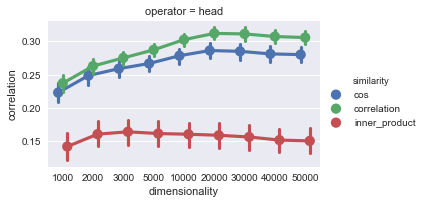

In [19]:
_ = t.plot_interaction(results['max'], feature_ablation_simlex.index[0], 'SimLex999', ylabels=['correlation'])

In [20]:
assert feature_ablation_simlex.index[0] == 'similarity'
r = results['max'].reset_index()

heuristics_selection_collection_simlex[0] = r.loc[
    r['similarity'] == 'correlation'
]

In [362]:
_ = (
    results.loc['head', ('max', 'SimLex999')]
    .unstack(['similarity', 'dimensionality'])
)

(
    ((_['correlation'] - _['cos']) > 0.023)
    .sum(axis=0) / _.shape[0]
    
).round(2)

(_['correlation'].mean(axis=0) - _['cos'].mean(axis=0)) > 0.025

dimensionality
1000     False
2000     False
3000     False
5000     False
10000    False
20000     True
30000     True
40000     True
50000     True
dtype: bool

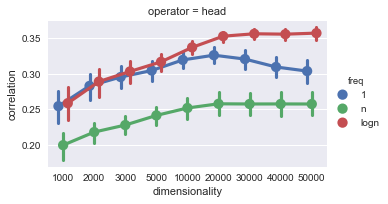

In [21]:
t.plot_interaction(heuristics_selection_collection_simlex[0], feature_ablation_simlex.index[1], 'SimLex999', ylabels=['correlation'])

In [22]:
assert feature_ablation_simlex.index[1] == 'freq'

r = heuristics_selection_collection_simlex[0]

heuristics_selection_collection_simlex[1] =  r.loc[
    r['freq'] == 'logn'
]

In [399]:
_ = (
    heuristics_selection_collection_simlex[0]
    .set_index(['operator'] + parameters).loc['head']['SimLex999']
    .unstack(['freq', 'similarity', 'dimensionality'])
)

(
    _['logn'].mean(axis=0) -
    _['1'].mean(axis=0)
) > 0.025

similarity   dimensionality
correlation  1000              False
             2000              False
             3000              False
             5000              False
             10000             False
             20000              True
             30000              True
             40000              True
             50000              True
dtype: bool

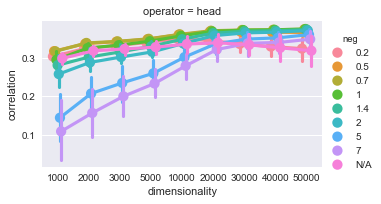

In [23]:
t.plot_interaction(heuristics_selection_collection_simlex[1], feature_ablation_simlex.index[2], 'SimLex999', ylabels=['correlation'])

In [24]:
assert feature_ablation_simlex.index[2] == 'neg'

r = heuristics_selection_collection_simlex[1]

heuristics_selection_collection_simlex[2] =  r.loc[
    (r['neg'] == 0.7)
]

In [449]:
_ = (
    heuristics_selection_collection_simlex[1]
    .set_index(['operator'] + parameters).loc['head']['SimLex999']
    .unstack(['neg', 'dimensionality'])
)
(
    _.mean(axis=0).unstack('neg').apply(lambda c: _[0.7].mean() - c, axis=0)
) > 0.025


neg               0.2    0.5    0.7    1.0    1.4    2.0    5.0   7.0    N/A
dimensionality                                                              
1000            False  False  False  False   True   True   True  True  False
2000            False  False  False  False   True   True   True  True  False
3000            False  False  False  False   True   True   True  True  False
5000            False  False  False  False  False   True   True  True  False
10000           False  False  False  False  False  False   True  True   True
20000           False  False  False  False  False  False   True  True   True
30000            True  False  False  False  False  False  False  True   True
40000            True  False  False  False  False  False  False  True   True
50000            True  False  False  False  False  False  False  True   True

In [440]:
# x.apply(lambda c: c * - 1, axis=1)

In [25]:
# Skip dimensionality
assert feature_ablation_simlex.index[3] == 'dimensionality'

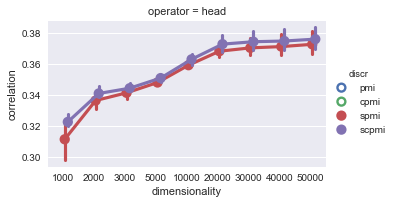

In [26]:
t.plot_interaction(heuristics_selection_collection_simlex[2], feature_ablation_simlex.index[4], 'SimLex999', ylabels=['correlation'])

In [27]:
assert feature_ablation_simlex.index[4] == 'discr'

r = heuristics_selection_collection_simlex[2]

heuristics_selection_collection_simlex[3] =  r.loc[
    (r['discr'] == 'scpmi')
]

In [452]:
_ = (
    heuristics_selection_collection_simlex[2]
    .set_index(['operator'] + parameters).loc['head']['SimLex999']
    .unstack(['discr', 'dimensionality'])
)
_
(
    np.abs(_['scpmi'].mean(axis=0) - _['spmi'].mean(axis=0))
) > 0.025

dimensionality
1000     False
2000     False
3000     False
5000     False
10000    False
20000    False
30000    False
40000    False
50000    False
dtype: bool

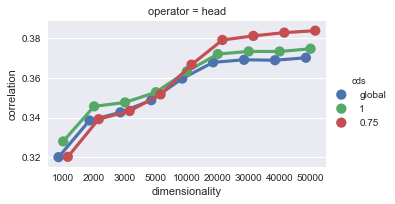

In [28]:
t.plot_interaction(heuristics_selection_collection_simlex[3], feature_ablation_simlex.index[5], 'SimLex999', ylabels=['correlation'])

In [29]:
assert feature_ablation_simlex.index[5] == 'cds'

r = heuristics_selection_collection_simlex[3]

heuristics_selection_collection_simlex[4] =  r.loc[
    # *skip tuning for 50K
    (~(r['dimensionality'] < 10000) | ((r['cds'] == '1'))) &
    (~(r['dimensionality'] >= 10000) | ((r['cds'] == '0.75'))) &
    True
]

In [454]:
_ = (
    heuristics_selection_collection_simlex[2]
    .set_index(['operator'] + parameters).loc['head']['SimLex999']
    .unstack(['cds', 'dimensionality'])
)
_
(
#     _.mean(axis=0).unstack('neg').apply(lambda c: _[0.7].mean() - c, axis=0)
#     np.abs(_['scpmi'].mean(axis=0) - _['spmi'].mean(axis=0))
) > 0.025

cds                            0.75                                      \
dimensionality                1000     2000     3000     5000     10000   
discr freq neg similarity                                                 
scpmi logn 0.7 correlation  0.32018  0.33918  0.34329  0.35164  0.36663   
spmi  logn 0.7 correlation  0.29805  0.33076  0.33721  0.34640  0.36140   

cds                                                                   1  \
dimensionality                20000    30000    40000    50000    1000    
discr freq neg similarity                                                 
scpmi logn 0.7 correlation  0.37908  0.38114  0.38279  0.38377  0.32795   
spmi  logn 0.7 correlation  0.37386  0.37717  0.37957  0.38175  0.31227   

cds                          ...               global                    \
dimensionality               ...       50000    1000     2000     3000    
discr freq neg similarity    ...                                          
scpmi logn 0.7 correlation   ...     0.37467  0.32001  0.33851  0.34260   
spmi  logn 0.7 correlation   ...     0.37001  0.32420  0.34072  0.34474   

cds                                                                      \
dimensionality                5000     10000    20000    30000    40000   
discr freq neg similarity                                                 
scpmi logn 0.7 correlation  0.34873  0.35963  0.36783  0.36910  0.36888   
spmi  logn 0.7 correlation  0.34933  0.35771  0.36446  0.36583  0.36598   

cds                                  
dimensionality                50000  
discr freq neg similarity            
scpmi logn 0.7 correlation  0.37013  
spmi  logn 0.7 correlation  0.36677  

[2 rows x 27 columns]

In [30]:
assert len(feature_ablation_simlex) == 6

In [31]:
heuristics_selection_simlex = heuristics_selection_collection_simlex[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_simlex['selection'] = 'heuristics'

## MEN

In [32]:
t.anova(
    response='men',
    predictors=parameters,
    data=results,
).rsquared_adj

0.73306515868630373

In [33]:
feature_ablation_men = t.calculate_feature_ablation(
    responses=(
        'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_men.sort_values(('partial R2', 'men'), ascending=False, inplace=True)

feature_ablation_men.round(2)

partial R2
response              men
predictor                
neg                  0.31
freq                 0.21
similarity           0.18
discr                0.12
dimensionality       0.11
cds                  0.09

In [34]:
(
    feature_ablation_men['partial R2']
    .reset_index()
    .round({'men': 2})
    .to_latex('figures/men-ablation.tex', index=False)
)

In [35]:
heuristics_selection_collection_men = {}

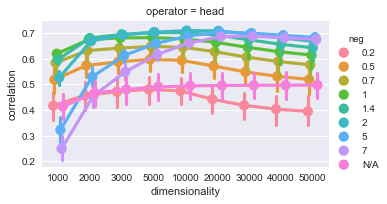

In [36]:
t.plot_interaction(results['max'], feature_ablation_men.index[0], 'men', ylabels=['correlation'])

In [37]:
assert feature_ablation_men.index[0] == 'neg'

r = results['max'].reset_index()

heuristics_selection_collection_men[0] =  r.loc[
    # *coarse selection
    (~(r['dimensionality'] < 20000) | ((r['neg'] == 2) | (r['neg'] == 'N/A'))) &
    (~(r['dimensionality'] >= 20000) | ((r['neg'] == 5) | (r['neg'] == 'N/A'))) &
    True
]

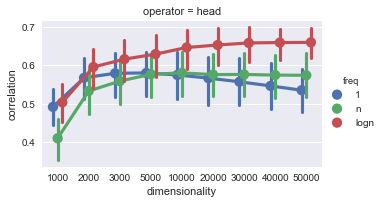

In [38]:
t.plot_interaction(heuristics_selection_collection_men[0], feature_ablation_men.index[1], 'men', ylabels=['correlation'])

In [39]:
assert feature_ablation_men.index[1] == 'freq'

r = heuristics_selection_collection_men[0]

heuristics_selection_collection_men[1] =  r.loc[
    (r['freq'] == 'logn')
]

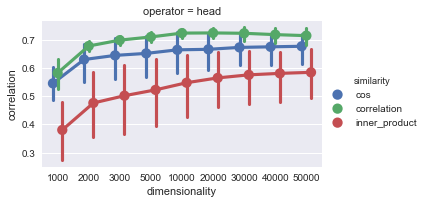

In [40]:
t.plot_interaction(heuristics_selection_collection_men[1], feature_ablation_men.index[2], 'men', ylabels=['correlation'])

In [41]:
assert feature_ablation_men.index[2] == 'similarity'

r = heuristics_selection_collection_men[1]

heuristics_selection_collection_men[2] =  r.loc[
    (r['similarity'] == 'correlation')
]

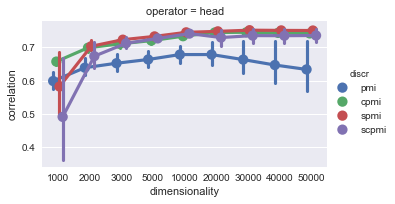

In [42]:
t.plot_interaction(heuristics_selection_collection_men[2], feature_ablation_men.index[3], 'men', ylabels=['correlation'])

In [43]:
assert feature_ablation_men.index[3] == 'discr'

r = heuristics_selection_collection_men[2]

heuristics_selection_collection_men[3] =  r.loc[
    (r['discr'] == 'spmi')
]

In [44]:
# Skip dimensionality
assert feature_ablation_men.index[4] == 'dimensionality'

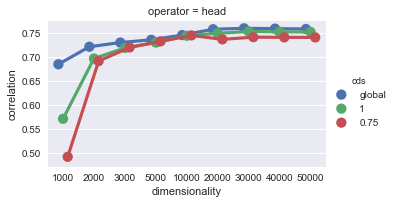

In [45]:
t.plot_interaction(heuristics_selection_collection_men[3], feature_ablation_men.index[5], 'men', ylabels=['correlation'])

In [46]:
assert feature_ablation_men.index[5] == 'cds'

r = heuristics_selection_collection_men[3]

heuristics_selection_collection_men[4] =  r.loc[
    (r['cds'] == 'global')
]

In [47]:
assert len(feature_ablation_men) == 6

In [48]:
heuristics_selection_men = heuristics_selection_collection_men[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_men['selection'] = 'heuristics'

#  Parameter selection comparison

In [50]:
'{:.2f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_simlex,
        'SimLex999',
    ),
)

'0.04'

In [51]:
'{:.2f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_men,
        'men',
    ),
)

'0.01'

/Users/dimazest/miniconda3/envs/notebook/lib/python3.6/site-packages/matplotlib/transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


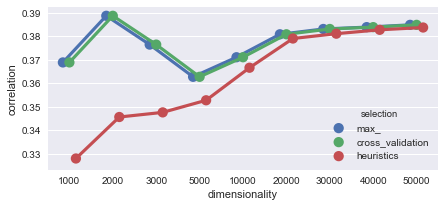

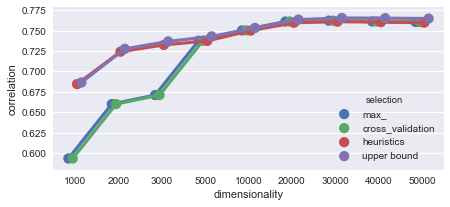

In [52]:
f, ax = plt.subplots(figsize=(7, 3))

t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,
    ],
    'SimLex999',
    ax=ax,
    ylabel='correlation',
)
f.savefig('figures/SimLex999-results.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,

        max_selection_men.assign(selection='upper bound')
    ],
    'SimLex999',
    'men',
    ax=ax,
    ylabel='correlation',
)

f.savefig('figures/SimLex999-transfer.pdf')

In [54]:
max_selection_simlex.sort_index().round({'SimLex999': 2}).loc['head'].reset_index(drop=True).to_latex(
    'figures/SimLex999-max_-selection.tex',
    columns=[
        'dimensionality',
        'SimLex999',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [55]:
heuristics_selection_simlex.sort_index().round({'SimLex999': 2}).loc['head'].reset_index(drop=True).to_latex(
    'figures/SimLex999-heuristics-selection.tex',
    columns=[
        'dimensionality',
        'SimLex999',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

#### MEN

In [56]:
max_selection_men.sort_index().round({'men': 2}).loc['head'].reset_index(drop=True).to_latex(
    'figures/men-max_-selection.tex',
    columns=[
        'dimensionality',
        'men',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [57]:
heuristics_selection_men.sort_index().round({'men': 2}).loc['head'].reset_index(drop=True).to_latex(
    'figures/men-heuristics-selection.tex',
    columns=[
        'dimensionality',
        'men',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

/Users/dimazest/miniconda3/envs/notebook/lib/python3.6/site-packages/matplotlib/transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


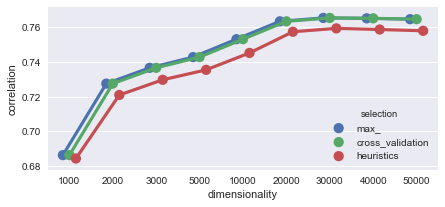

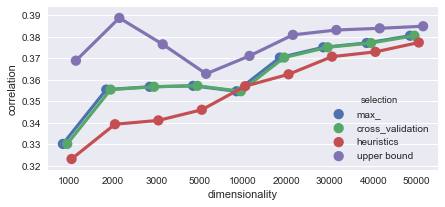

In [58]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,
    ],
    'men',
    ax=ax,
    ylabel='correlation',
)
f.savefig('figures/men-results.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,

        max_selection_simlex.assign(selection='upper bound')
    ],
    'men',
    'SimLex999',
    ax=ax,
    ylabel='correlation',
)
f.savefig('figures/men-transfer.pdf')

In [59]:
'SimLex-999 to MEN (heuristics): {:.2f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_simlex,
        'men',
    ),
)

'SimLex-999 to MEN (heuristics): 0.01'

In [60]:
'SimLex-999 to MEN (max): {:.2f}'.format(
    t.average_error(
        max_selection_men,
        max_selection_simlex,
        'men',
    ),
)

'SimLex-999 to MEN (max): 0.04'

In [61]:
'MEN to SimLex999 (heuristics): {:.2f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_men,
        'SimLex999',
    ),
)

'MEN to SimLex999 (heuristics): 0.06'

In [62]:
'MEN to SimLex999 (heuristics): {:.2f}'.format(
    t.average_error(
        max_selection_simlex,
        max_selection_men,
        'SimLex999',
    ),
)

'MEN to SimLex999 (heuristics): 0.04'

## Union

In [63]:
results['max', 'lexical'] = (
    (
        (results['max', 'SimLex999'] / results['max', 'SimLex999'].max()) +
        (results['max', 'men'] / results['max', 'men'].max())
    ) / 2
)

In [64]:
max_selection_lexical = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='lexical',
    selector_function=t.max_('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel'),
    plot=False,
)

#### Heuristics

In [65]:
'{:.2f}'.format(
        t.anova(
        response='lexical',
        predictors=parameters,
        data=results[results.index.get_level_values('operator') == 'head'],
    ).rsquared_adj
)

'0.82'

In [67]:
feature_ablation_lexical = t.calculate_feature_ablation(
    responses=(
        'lexical',
    ),
    predictors=parameters,
    data=results[results.index.get_level_values('operator') == 'head'],
)

feature_ablation_lexical.sort_values(('partial R2', 'lexical'), ascending=False, inplace=True)

feature_ablation_lexical.round(2)

partial R2
response          lexical
predictor                
similarity           0.30
neg                  0.28
freq                 0.23
dimensionality       0.09
discr                0.09
cds                  0.08

In [68]:
(
    feature_ablation_lexical['partial R2']
    .reset_index()
    .round({'lexical': 2})
    .to_latex('figures/lexical-ablation.tex', index=False)
)

In [69]:
heuristics_selection_collection_lexical = {}

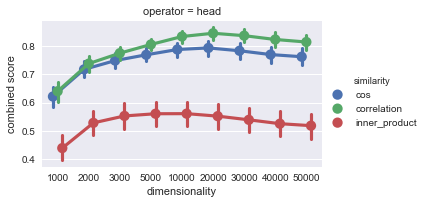

In [70]:
t.plot_interaction(results[results.index.get_level_values('operator') == 'head']['max'], feature_ablation_lexical.index[0], 'lexical', ylabels=['combined score'])

In [71]:
assert feature_ablation_lexical.index[0] == 'similarity'

r = results[results.index.get_level_values('operator') == 'head']['max'].reset_index()

heuristics_selection_collection_lexical[0] = r.loc[
    r['similarity'] == 'correlation'
]

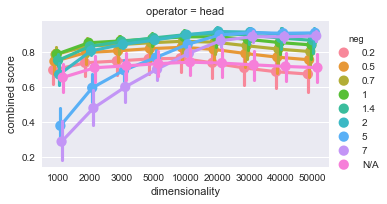

In [72]:
t.plot_interaction(heuristics_selection_collection_lexical[0], feature_ablation_lexical.index[1], 'lexical', ylabels=['combined score'])

In [73]:
assert feature_ablation_lexical.index[1] == 'neg'

r = heuristics_selection_collection_lexical[0]

heuristics_selection_collection_lexical[1] =  r.loc[
    (~(r['dimensionality'] < 20000) | (r['neg'] == 1)) &
    (~(r['dimensionality'] >= 20000) | (r['neg'] == 2)) &

    True
]

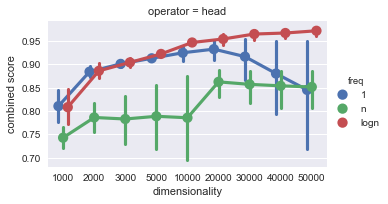

In [74]:
t.plot_interaction(heuristics_selection_collection_lexical[1], feature_ablation_lexical.index[2], 'lexical', ylabels=['combined score'])

In [75]:
assert feature_ablation_lexical.index[2] == 'freq'

r = heuristics_selection_collection_lexical[1]

heuristics_selection_collection_lexical[2] =  r.loc[
    r['freq'] == 'logn'
]

In [76]:
assert feature_ablation_lexical.index[3] == 'dimensionality'

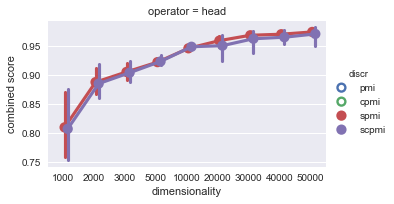

In [77]:
t.plot_interaction(heuristics_selection_collection_lexical[2], feature_ablation_lexical.index[4], 'lexical', ylabels=['combined score'])

In [78]:
assert feature_ablation_lexical.index[4] == 'discr'

r = heuristics_selection_collection_lexical[2]

heuristics_selection_collection_lexical[3] =  r.loc[
    r['discr'] == 'scpmi'
]

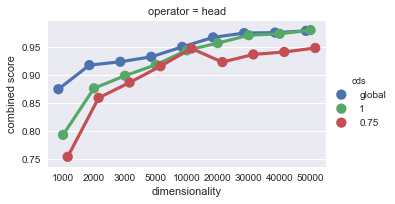

In [79]:
t.plot_interaction(heuristics_selection_collection_lexical[3], feature_ablation_lexical.index[5], 'lexical', ylabels=['combined score'])

In [80]:
assert feature_ablation_lexical.index[5] == 'cds'

r = heuristics_selection_collection_lexical[3]

heuristics_selection_collection_lexical[4] =  r.loc[
    r['cds'] == 'global'
]

In [81]:
assert len(feature_ablation_lexical) == 6

In [82]:
heuristics_selection_lexical = heuristics_selection_collection_lexical[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_lexical['selection'] = 'heuristics'

In [83]:
max_selection_lexical.sort_index().round(
    {
        'men': 2,
        'SimLex999': 2,
        'lexical': 2,
    }
).loc['head'].reset_index(drop=True).to_latex(
    'figures/lexical-max-selection.tex',
    columns=[
        'dimensionality',
        'SimLex999',
        'men',
        'lexical',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [84]:
heuristics_selection_lexical.sort_index().round(
    {
        'men': 2,
        'SimLex999': 2,
        'lexical': 2,
    }
).loc['head'].reset_index(drop=True).to_latex(
    'figures/lexical-heuristics-selection.tex',
    columns=[
        'dimensionality',
        'SimLex999',
        'men',
        'lexical',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

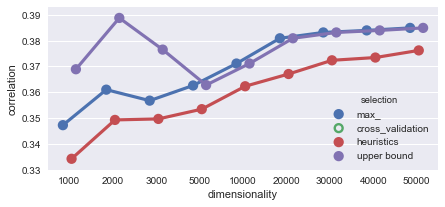

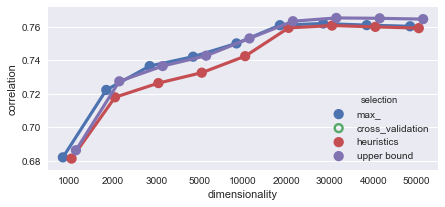

In [85]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,
        
        max_selection_simlex.assign(selection='upper bound')
    ],
    'SimLex999',
    'SimLex999',
    ax=ax,
    ylabel='correlation'
)
f.savefig('figures/lexical-results-SimLex999.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_men.assign(selection='upper bound'),
    ],
    'men',
    'men',
    ax=ax,
    ylabel='correlation'
)
f.savefig('figures/lexical-results-men.pdf')

In [86]:
'Lexical on SimLex999 (max): {:.2f}'.format(
    t.average_error(
        max_selection_simlex,
        max_selection_lexical,
        'SimLex999',
    ),
)

'Lexical on SimLex999 (max): 0.02'

In [90]:
'Lexical on men (max): {:.2f}'.format(
    t.average_error(
        max_selection_men,
        max_selection_lexical,
        'men',
    ),
)

'Lexical on men (max): 0.00'

In [91]:
'Lexical on SimLex999 (heuristics): {:.2f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_lexical,
        'SimLex999',
    ),
)

'Lexical on SimLex999 (heuristics): 0.05'

In [92]:
'Lexical on men (heuristics): {:.2f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_lexical,
        'men',
    ),
)

'Lexical on men (heuristics): 0.01'

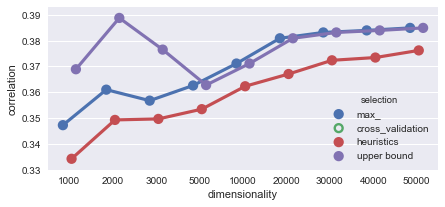

In [93]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_simlex.assign(selection='upper bound')
    ],
    'lexical',
    'SimLex999',
    ax=ax,
    ylabel='correlation'
)
# f.savefig('figures/SimLex999-transfer.pdf')

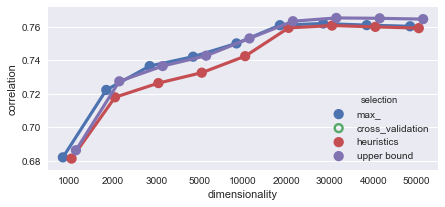

In [94]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_men.assign(selection='upper bound')
    ],
    'lexical',
    'men',
    ax=ax,
    ylabel='correlation'
)
# f.savefig('figures/SimLex999-transfer.pdf')

# Compositional

## Max

In [95]:
max_selection_ks14 = t.plot_selection(
    results[results['max', 'KS14'].notnull()],
    dataset='KS14',
    selector_function=t.max_('GS11', 'PhraseRel'),
    plot=False,
)

In [96]:
max_selection_gs11 = t.plot_selection(
    results[results['max', 'GS11'].notnull()],
    dataset='GS11',
    selector_function=t.max_('KS14', 'PhraseRel'),
    plot=False,
)

In [97]:
max_selection_phraserel = t.plot_selection(
    results,#[results['max', 'PhraseRel'].notnull()],
    dataset='PhraseRel',
    selector_function=t.max_('KS14', 'GS11'),
    plot=False,
)

## Cross-validation

In [98]:
cross_validation_selection_ks14 = t.plot_selection(
    results[results['max', 'KS14'].notnull()],
    dataset='KS14',
    selector_function=t.cross_validation('GS11', 'PhraseRel'),
    plot=False,
)

In [99]:
cross_validation_selection_gs11= t.plot_selection(
    results[results['max', 'GS11'].notnull()],
    dataset='GS11',
    selector_function=t.cross_validation('KS14', 'PhraseRel'),
    plot=False,
)

In [100]:
cross_validation_selection_phraserel = t.plot_selection(
    results[results['max', 'PhraseRel'].notnull()],
    dataset='PhraseRel',
    selector_function=t.cross_validation('KS14', 'GS11'),
    plot=False,
)

## Heuristics 

In [101]:
compositional_parameters = parameters + ['operator']

## KS14

In [102]:
'{:.2f}'.format(
        t.anova(
        response='KS14',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.79'

In [103]:
feature_ablation_ks14 = t.calculate_feature_ablation(
    responses=(
        'KS14',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_ks14.sort_values(('partial R2', 'KS14'), ascending=False, inplace=True)

feature_ablation_ks14.round(2)

partial R2
response             KS14
predictor                
neg                  0.33
freq                 0.31
operator             0.30
cds                  0.14
similarity           0.06
discr                0.05
dimensionality       0.03

In [104]:
(
    feature_ablation_ks14['partial R2']
    .reset_index()
    .round({'KS14': 2})
    .to_latex('figures/ks14-ablation.tex', index=False)
)

In [105]:
heuristics_selection_collection_ks14 = {}

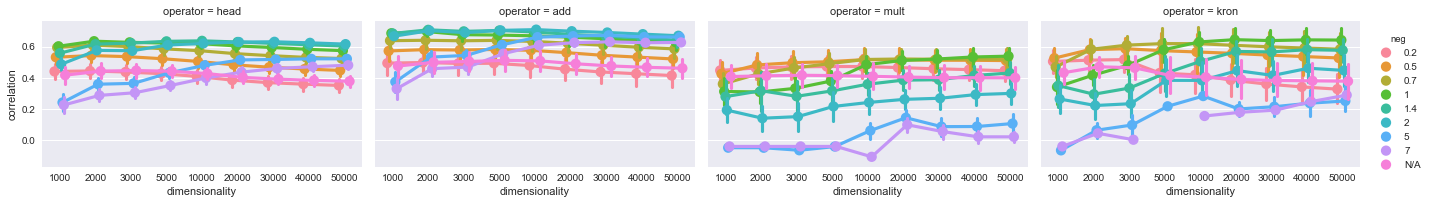

In [106]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_ks14.index[0], 'KS14', ylabels=['correlation'])

In [107]:
assert feature_ablation_ks14.index[0] == 'neg'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_ks14[0] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 5000)) | ((r['neg'] == 1))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 5000) & (r['dimensionality'] < 30000)) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 30000)) | ((r['neg'] == 2))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 2))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 10000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 10000) & (r['dimensionality'] < 30000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 30000)) | ((r['neg'] == 1))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 3000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 3000) & (r['dimensionality'] < 20000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 1))) &

    True
]

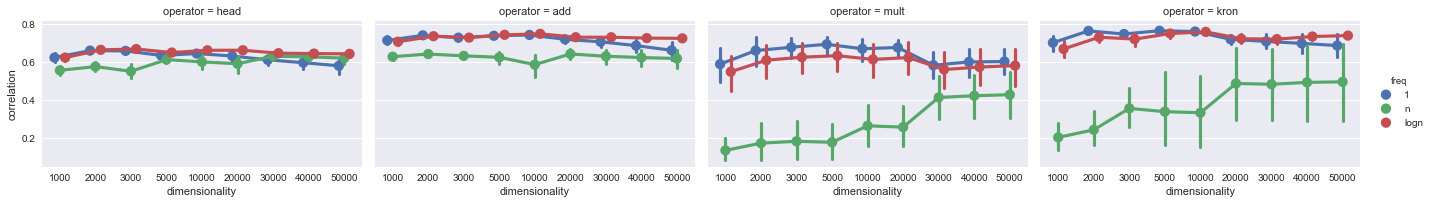

In [108]:
t.plot_interaction(heuristics_selection_collection_ks14[0], feature_ablation_ks14.index[1], 'KS14', ylabels=['correlation'])

In [109]:
assert feature_ablation_ks14.index[1] == 'freq'

r = heuristics_selection_collection_ks14[0]

heuristics_selection_collection_ks14[1] =  r.loc[
    (~((r['operator'] == 'head')) | (r['freq'] == 'logn')) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 5000)) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 5000)) | ((r['freq'] == 'logn'))) &

    (~((r['operator'] == 'mult')) | (r['freq'] == '1')) &
     
    (~((r['operator'] == 'kron') & (r['dimensionality'] < 10000)) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 10000)) | ((r['freq'] == 'logn'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[1], 'KS14')

In [110]:
assert feature_ablation_ks14.index[2] == 'operator'

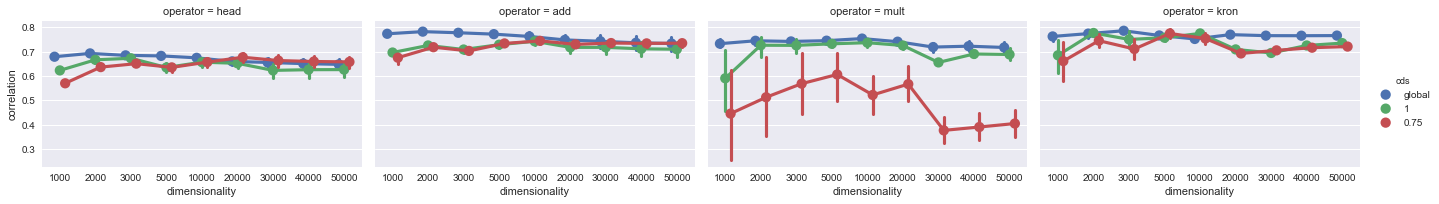

In [111]:
t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[3], 'KS14', ylabels=['correlation'])

In [112]:
assert feature_ablation_ks14.index[3] == 'cds'

r = heuristics_selection_collection_ks14[1]

heuristics_selection_collection_ks14[2] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 20000)) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 20000)) | ((r['cds'] == '0.75'))) &

    (~((r['operator'] == 'add')) | (r['cds'] == 'global')) &
    (~((r['operator'] == 'mult')) | (r['cds'] == 'global')) &
    (~((r['operator'] == 'kron')) | (r['cds'] == 'global')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[1], 'KS14')

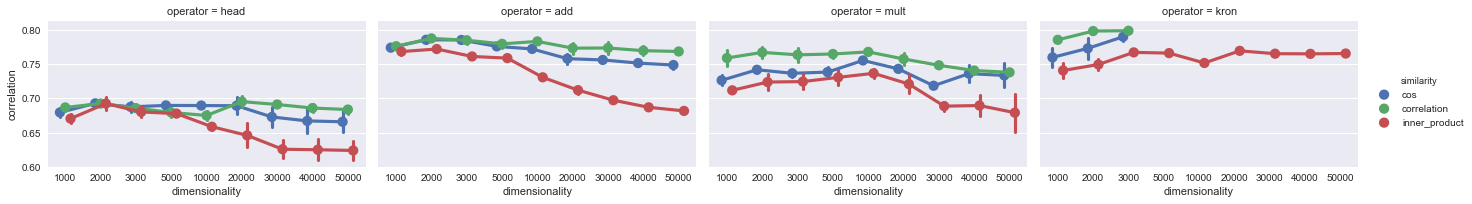

In [113]:
t.plot_interaction(heuristics_selection_collection_ks14[2], feature_ablation_ks14.index[4], 'KS14', ylabels=['correlation'])

In [114]:
assert feature_ablation_ks14.index[4] == 'similarity'

r = heuristics_selection_collection_ks14[2]

heuristics_selection_collection_ks14[3] =  r.loc[
    (~((r['operator'] == 'head') &  (r['dimensionality'] < 20000)) | (r['similarity'] == 'cos')) &
    (~((r['operator'] == 'head') &  (r['dimensionality'] >= 20000)) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'add')) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'mult')) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'kron') &  (r['dimensionality'] < 5000)) | (r['similarity'] == 'correlation')) &
    (~((r['operator'] == 'kron') &  (r['dimensionality'] >= 5000)) | (r['similarity'] == 'inner_product')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[3], feature_ablation_ks14.index[4], 'KS14')

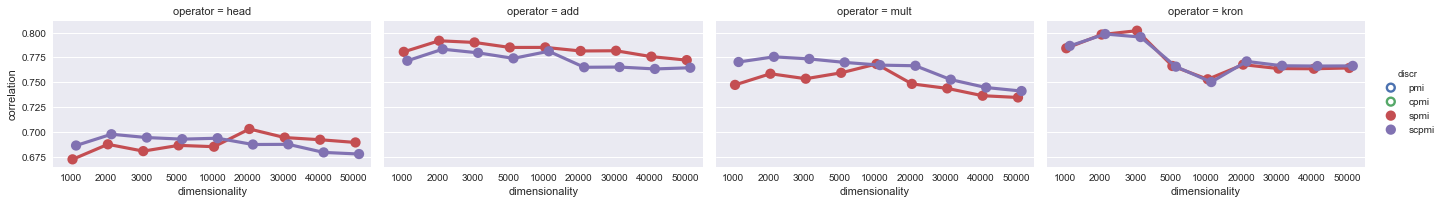

In [115]:
t.plot_interaction(heuristics_selection_collection_ks14[3], feature_ablation_ks14.index[5], 'KS14', ylabels=['correlation'])

In [116]:
assert feature_ablation_ks14.index[5] == 'discr'

r = heuristics_selection_collection_ks14[3]

heuristics_selection_collection_ks14[4] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 20000)) | (r['discr'] == 'scpmi')) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 20000)) | (r['discr'] == 'spmi')) &

    (~((r['operator'] == 'add')) | (r['discr'] == 'spmi')) &

    (~((r['operator'] == 'mult')) | (r['discr'] == 'scpmi')) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 20000)) | (r['discr'] == 'spmi')) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | (r['discr'] == 'scpmi')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[4], feature_ablation_ks14.index[5], 'KS14')

In [117]:
assert feature_ablation_ks14.index[6] == 'dimensionality'

In [118]:
assert len(feature_ablation_ks14) == 7

In [119]:
heuristics_selection_ks14 = heuristics_selection_collection_ks14[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_ks14['selection'] = 'heuristics'
heuristics_selection_ks14.sort_index(inplace=True)

In [120]:
t.plot_selection(
    heuristics_selection_ks14,
    dataset='KS14',
    selector_function='heuristics',
    plot=False,
)

In [122]:
pd.concat(
    [
        max_selection_ks14.loc[
            ['head', '']
        ],        
        max_selection_ks14.loc[
            ['add', 'mult']
        ],
        max_selection_ks14.loc[
            ['kron', '']
        ],        
    ]
).round({'KS14': 2}).reset_index(drop=True).to_latex(
    'figures/ks14-max-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'KS14',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
    
)

In [123]:
pd.concat(
    [
        heuristics_selection_ks14.loc[
            ['head', '']
        ],        
        heuristics_selection_ks14.loc[
            ['add', 'mult']
        ],
        heuristics_selection_ks14.loc[
            ['kron', '']
        ],        
    ]
).round({'KS14': 2}).reset_index(drop=True).to_latex(
    'figures/ks14-heuristics-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'KS14',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
    
)

## GS11

In [124]:
'{:.2f}'.format(
    t.anova(
        response='GS11',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.75'

In [125]:
feature_ablation_gs11 = t.calculate_feature_ablation(
    responses=(
        'GS11',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_gs11.sort_values(('partial R2', 'GS11'), ascending=False, inplace=True)

feature_ablation_gs11.round(2)

partial R2
response             GS11
predictor                
operator             0.37
freq                 0.21
neg                  0.18
similarity           0.09
cds                  0.05
discr                0.04
dimensionality       0.04

In [126]:
(
    feature_ablation_gs11['partial R2']
    .reset_index()
    .round({'GS11': 2})
    .to_latex('figures/gs11-ablation.tex', index=False)
)

In [127]:
heuristics_selection_collection_gs11 = {}

In [128]:
assert feature_ablation_gs11.index[0] == 'operator'

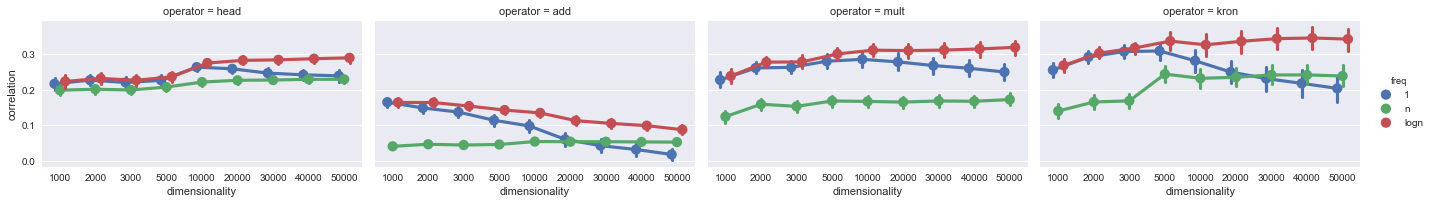

In [129]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_gs11.index[1], 'GS11', ylabels=['correlation'])

In [130]:
assert feature_ablation_gs11.index[1] == 'freq'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_gs11[0] =  r.loc[
    (r['freq'] == 'logn')
]

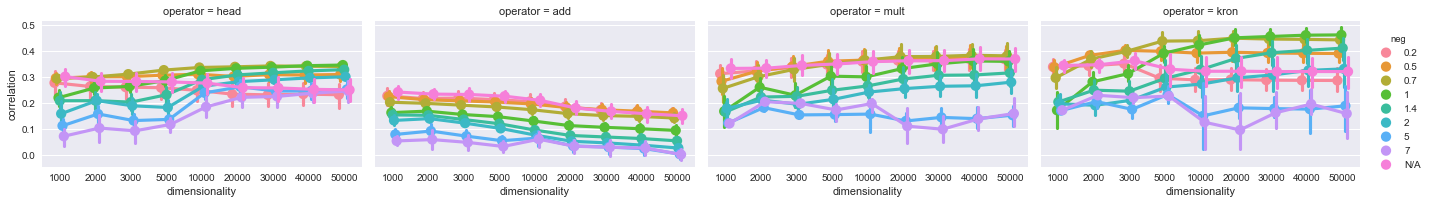

In [131]:
t.plot_interaction(heuristics_selection_collection_gs11[0], feature_ablation_gs11.index[2], 'GS11', ylabels=['correlation'])

In [132]:
assert feature_ablation_gs11.index[2] == 'neg'

r = heuristics_selection_collection_gs11[0]

heuristics_selection_collection_gs11[1] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 3000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 3000)) | ((r['neg'] == 0.7))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['neg'] == 'N/A'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 0.2))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 5000)) | ((r['neg'] == 'N/A'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 5000)) | ((r['neg'] == 0.7))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 20000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 1))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[1], feature_ablation_gs11.index[2], 'GS11')

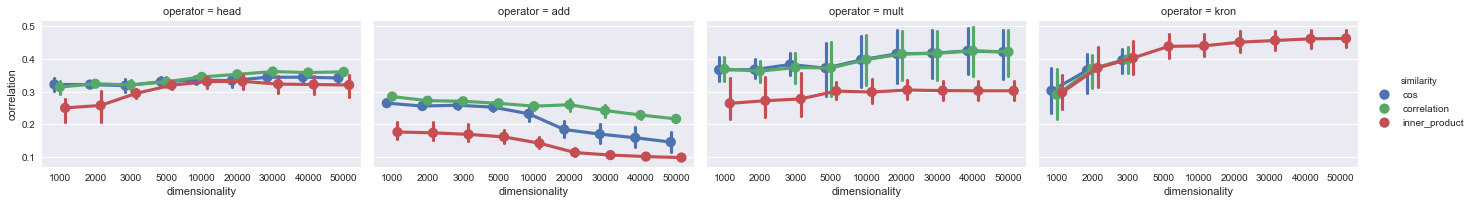

In [133]:
t.plot_interaction(heuristics_selection_collection_gs11[1], feature_ablation_gs11.index[3], 'GS11', ylabels=['correlation'])

In [134]:
assert feature_ablation_gs11.index[3] == 'similarity'

r = heuristics_selection_collection_gs11[1]

heuristics_selection_collection_gs11[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'add')) | ((r['similarity'] == 'correlation'))) &
    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'kron')) | ((r['similarity'] == 'inner_product'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[2], feature_ablation_gs11.index[3], 'GS11')

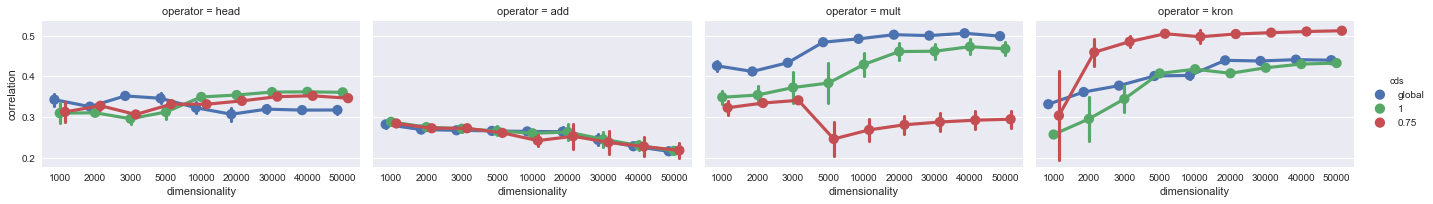

In [135]:
t.plot_interaction(heuristics_selection_collection_gs11[2], feature_ablation_gs11.index[4], 'GS11', ylabels=['correlation'])

In [136]:
assert feature_ablation_gs11.index[4] == 'cds'

r = heuristics_selection_collection_gs11[2]

heuristics_selection_collection_gs11[3] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 10000)) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 10000)) | ((r['cds'] == '1'))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['cds'] == '1'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['cds'] == '0.75'))) &

    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &

    (~((r['operator'] == 'kron')) | ((r['cds'] == '0.75'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[3], feature_ablation_gs11.index[4], 'GS11')

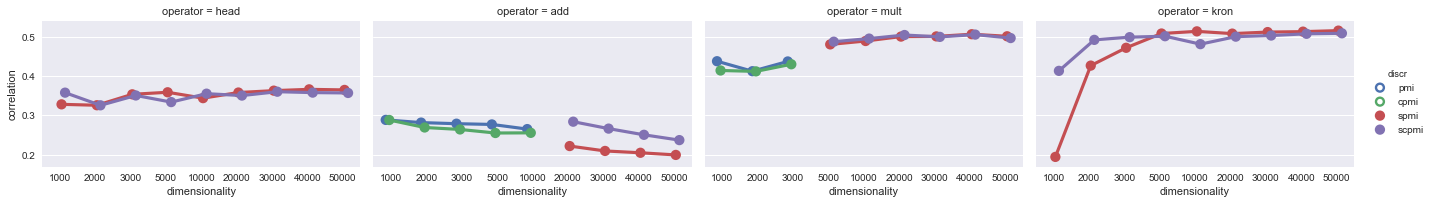

In [137]:
t.plot_interaction(heuristics_selection_collection_gs11[3], feature_ablation_gs11.index[5], 'GS11', ylabels=['correlation'])

In [138]:
assert feature_ablation_gs11.index[5] == 'discr'

r = heuristics_selection_collection_gs11[3]

heuristics_selection_collection_gs11[4] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['discr'] == 'spmi'))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['discr'] == 'pmi'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'pmi'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'scpmi'))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'spmi'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[4], feature_ablation_gs11.index[5], 'GS11')

In [139]:
assert feature_ablation_gs11.index[6] == 'dimensionality'

In [140]:
assert len(feature_ablation_gs11) == 7

In [141]:
heuristics_selection_gs11 = heuristics_selection_collection_gs11[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_gs11['selection'] = 'heuristics'
heuristics_selection_gs11.sort_index(inplace=True)

In [142]:
t.plot_selection(
    heuristics_selection_gs11,
    dataset='GS11',
    selector_function='heuristics',
    plot=False,
)

##  Phraserel

In [143]:
'{:.2f}'.format(
    t.anova(
        response='PhraseRel',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.82'

In [144]:
feature_ablation_phraserel = t.calculate_feature_ablation(
    responses=(
        'PhraseRel',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_phraserel.sort_values(('partial R2', 'PhraseRel'), ascending=False, inplace=True)

feature_ablation_phraserel.round(2)

partial R2
response        PhraseRel
predictor                
neg                  0.58
operator             0.35
cds                  0.08
freq                 0.04
similarity           0.03
dimensionality       0.03
discr                0.02

In [145]:
(
    feature_ablation_phraserel['partial R2']
    .reset_index()
    .round({'PhraseRel': 2})
    .to_latex('figures/phraserel-ablation.tex', index=False)
)

In [146]:
heuristics_selection_collection_phraserel = {}

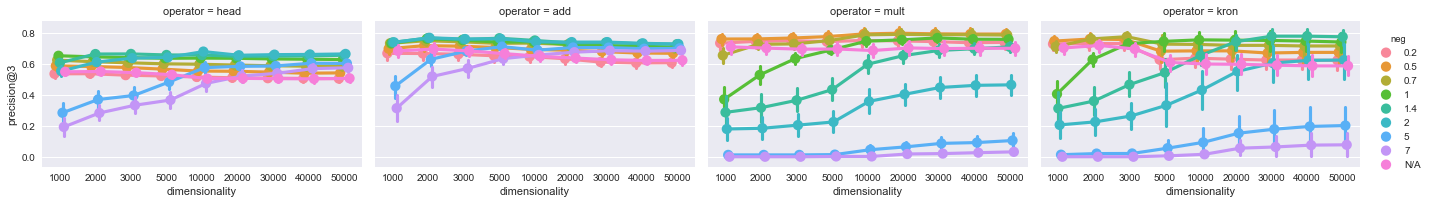

In [147]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_phraserel.index[0], 'PhraseRel', ylabels=['precision@3'])

In [148]:
assert feature_ablation_phraserel.index[0] == 'neg'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_phraserel[0] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'add')) | ((r['neg'] == 2))) &
    (~((r['operator'] == 'mult')) | ((r['neg'] == 0.5))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['neg'] == 0.5))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000) & (r['dimensionality'] < 20000))) | ((r['neg'] == 1))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 20000))) | ((r['neg'] == 1.4))) &

    True
]

In [149]:
assert feature_ablation_phraserel.index[1] == 'operator'

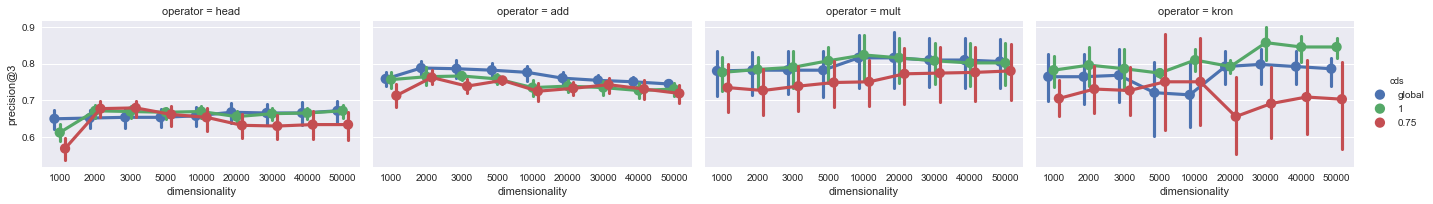

In [150]:
t.plot_interaction(heuristics_selection_collection_phraserel[0], feature_ablation_phraserel.index[2], 'PhraseRel', ylabels=['precision@3'])

In [151]:
assert feature_ablation_phraserel.index[2] == 'cds'

r = heuristics_selection_collection_phraserel[0]

heuristics_selection_collection_phraserel[1] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['cds'] == '0.75'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['cds'] == 'global'))) &

    (~((r['operator'] == 'add')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'kron')) | ((r['cds'] == '1'))) &

    True
]

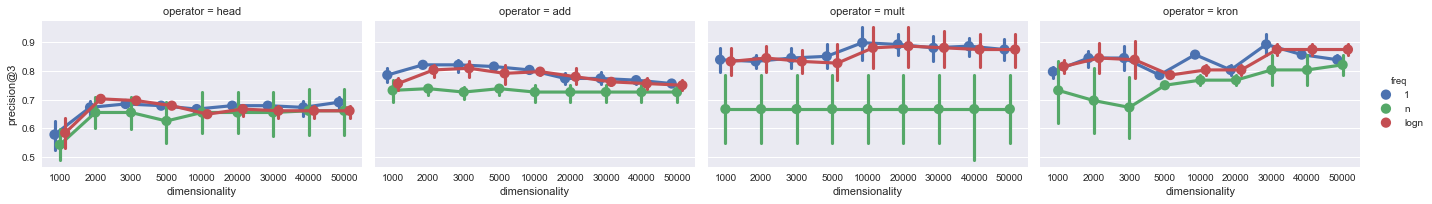

In [152]:
t.plot_interaction(heuristics_selection_collection_phraserel[1], feature_ablation_phraserel.index[3], 'PhraseRel', ylabels=['precision@3'])

In [153]:
assert feature_ablation_phraserel.index[3] == 'freq'

r = heuristics_selection_collection_phraserel[1]

heuristics_selection_collection_phraserel[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['freq'] == 'n'))) &
    (~((r['operator'] == 'add')) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'mult')) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['freq'] == 'logn'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['freq'] == '1'))) &

    True
]

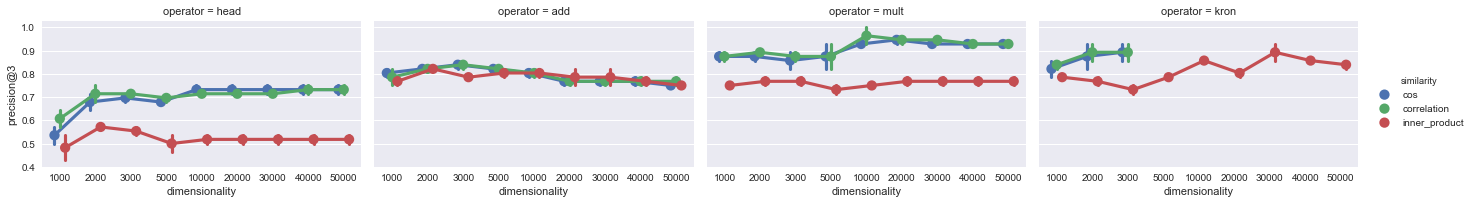

In [154]:
t.plot_interaction(heuristics_selection_collection_phraserel[2], feature_ablation_phraserel.index[4], 'PhraseRel', ylabels=['precision@3'])

In [155]:
assert feature_ablation_phraserel.index[4] == 'similarity'

r = heuristics_selection_collection_phraserel[2]

heuristics_selection_collection_phraserel[3] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['similarity'] == 'cos'))) &

    (~(((r['operator'] == 'add') & (r['dimensionality'] < 20000))) | ((r['similarity'] == 'cos'))) &
    (~(((r['operator'] == 'add') & (r['dimensionality'] >= 20000))) | ((r['similarity'] == 'inner_product'))) &

    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'correlation'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'inner_product'))) &

    True
]

In [156]:
assert feature_ablation_phraserel.index[5] == 'dimensionality'

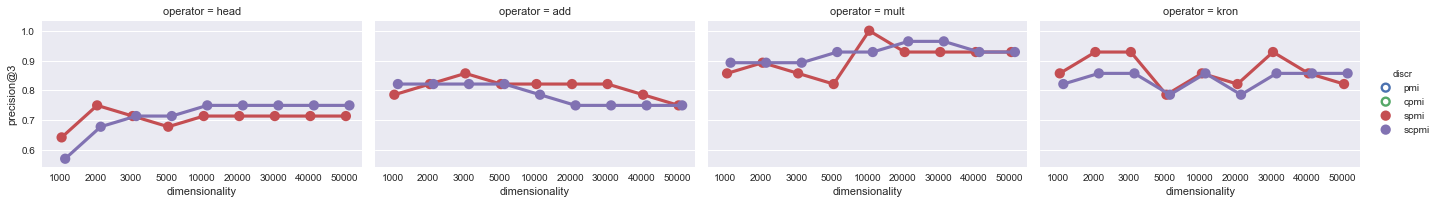

In [157]:
t.plot_interaction(heuristics_selection_collection_phraserel[3], feature_ablation_phraserel.index[6], 'PhraseRel', ylabels=['precision@3'])

In [158]:
assert feature_ablation_phraserel.index[6] == 'discr'

r = heuristics_selection_collection_phraserel[3]

heuristics_selection_collection_phraserel[4] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 5000))) | ((r['discr'] == 'spmi'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 5000))) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'add')) | ((r['discr'] == 'spmi'))) &
    (~((r['operator'] == 'mult')) | ((r['discr'] == 'scpmi'))) &
    (~((r['operator'] == 'kron')) | ((r['discr'] == 'spmi'))) &

    True
]

In [159]:
assert len(feature_ablation_phraserel) == 7

In [160]:
heuristics_selection_phraserel = heuristics_selection_collection_phraserel[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_phraserel['selection'] = 'heuristics'
heuristics_selection_phraserel.sort_index(inplace=True)

## Compositional comparison 

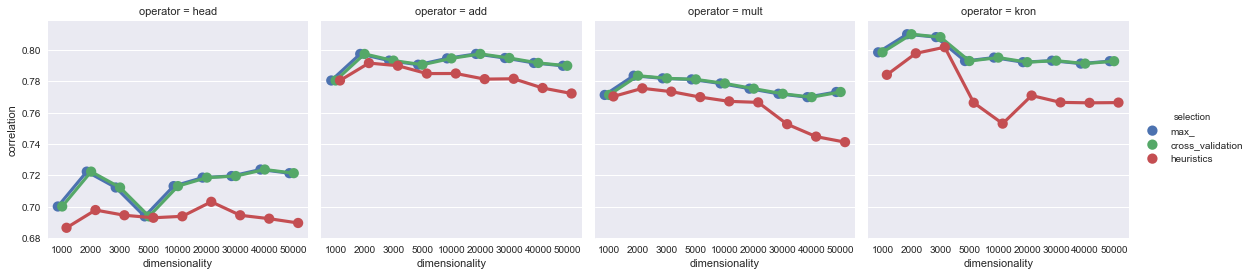

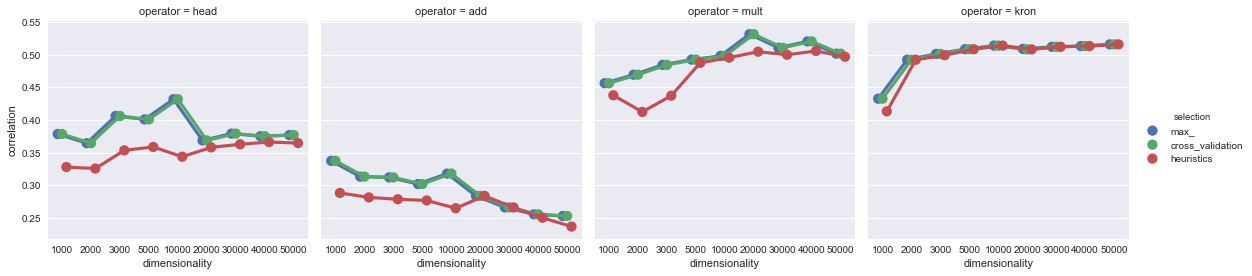

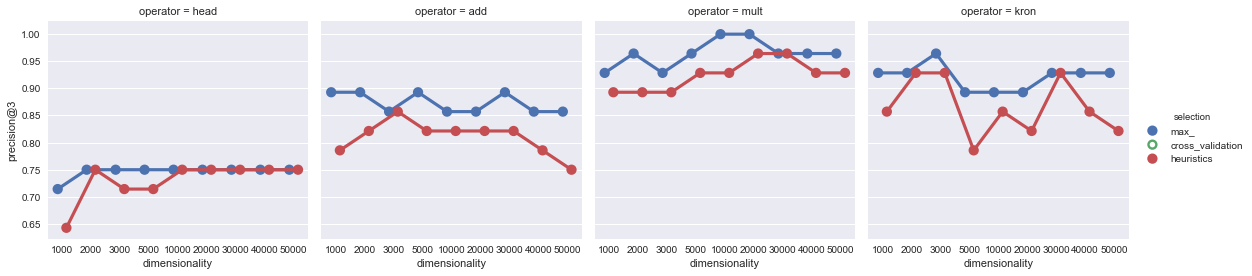

In [161]:
t.plot_parameter_selection_comparison(
    [
        max_selection_ks14,
        cross_validation_selection_ks14,
        heuristics_selection_ks14,
    ],
    'KS14',
    col='operator',
    ylabel='correlation'
).fig.savefig('figures/ks14-results.pdf')
    
t.plot_parameter_selection_comparison(
    [
        max_selection_gs11,
        cross_validation_selection_gs11,
        heuristics_selection_gs11,
    ],
    'GS11',
    col='operator',
    ylabel='correlation'
).fig.savefig('figures/gs11-results.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_phraserel,
        #cross_validation_selection_phraserel,
        heuristics_selection_phraserel,
    ],
    'PhraseRel',
    col='operator',
    ylabel='precision@3'
).fig.savefig('figures/phraserel-results.pdf')

In [163]:
pd.concat(
    [
        max_selection_gs11.loc[
            ['head']
        ],        
        max_selection_gs11.loc[
            ['add', 'mult']
        ],
        max_selection_gs11.loc[
            ['kron']
        ],        
    ]
).round({'GS11': 2}).reset_index(drop=True).to_latex(
    'figures/gs11-max-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'GS11',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [164]:
pd.concat(
    [
        heuristics_selection_gs11.loc[
            ['head', '']
        ],        
        heuristics_selection_gs11.loc[
            ['add', 'mult']
        ],
        heuristics_selection_gs11.loc[
            ['kron', '']
        ],        
    ]
).round({'GS11': 2}).reset_index(drop=True).to_latex(
    'figures/gs11-heuristics-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'GS11',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [165]:
pd.concat(
    [
        max_selection_phraserel.loc[
            ['head']
        ],        
        max_selection_phraserel.loc[
            ['add', 'mult']
        ],
        max_selection_phraserel.loc[
            ['kron']
        ],        
    ]
).round({'PhraseRel': 2}).reset_index(drop=True).to_latex(
    'figures/phraserel-max-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'PhraseRel',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [166]:
pd.concat(
    [
        heuristics_selection_phraserel.loc[
            ['head', '']
        ],        
        heuristics_selection_phraserel.loc[
            ['add', 'mult']
        ],
        heuristics_selection_phraserel.loc[
            ['kron', '']
        ],        
    ]
).round({'PhraseRel': 2}).reset_index(drop=True).to_latex(
    'figures/phraserel-heuristics-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'PhraseRel',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [167]:
dataset_mapping = {
    'KS14': [
        max_selection_ks14,
        cross_validation_selection_ks14,
        heuristics_selection_ks14,
    ],
    'GS11': [
        max_selection_gs11,
        cross_validation_selection_gs11,
        heuristics_selection_gs11,
    ],
    'PhraseRel': [
        max_selection_phraserel,
        #cross_validation_selection_phraserel,
        heuristics_selection_phraserel,
    ],
}

In [169]:
for dataset in 'KS14', 'GS11', 'PhraseRel':
    print(
        '{dataset}: {:.2f}'.format(
            t.average_error(
                dataset_mapping[dataset][0],
                dataset_mapping[dataset][-1],
                dataset,
            ),
            dataset=dataset,
        )
    )
    for operator in 'head', 'add', 'mult', 'kron':
        print(
            '{dataset}, {operator}: {:.2f}'.format(
                t.average_error(
                    dataset_mapping[dataset][0].loc[operator],
                    dataset_mapping[dataset][-1].loc[operator],
                    dataset,
                ),
                operator=operator,
                dataset=dataset,
            )
        )

KS14: 0.02
KS14, head: 0.03
KS14, add: 0.01
KS14, mult: 0.02
KS14, kron: 0.03
GS11: 0.05
GS11, head: 0.09
GS11, add: 0.08
GS11, mult: 0.04
GS11, kron: 0.01
PhraseRel: 0.05
PhraseRel, head: 0.02
PhraseRel, add: 0.07
PhraseRel, mult: 0.04
PhraseRel, kron: 0.06


In [170]:
for from_i, from_ in enumerate(('KS14', 'GS11', 'PhraseRel')):
    for to_i, to_ in enumerate(t for t in ('KS14', 'GS11', 'PhraseRel') if t != from_):
        for method_i, method in (0, 'max'), (-1, 'heuristics'):
            print(
                '{from_} -> {to_}, {method}: {:.2f}'.format(
                    t.average_error(
                        dataset_mapping[to_][0].loc[['head', 'add', 'mult', 'kron']],
                        dataset_mapping[from_][method_i].loc[['head', 'add', 'mult', 'kron']],
                        to_,
                    ),
                    from_=from_,
                    to_=to_,
                    method=method,
                )
            )

KS14 -> GS11, max: 0.34
KS14 -> GS11, heuristics: 0.24
KS14 -> PhraseRel, max: 0.09
KS14 -> PhraseRel, heuristics: 0.09
GS11 -> KS14, max: 0.12
GS11 -> KS14, heuristics: 0.11
GS11 -> PhraseRel, max: 0.13
GS11 -> PhraseRel, heuristics: 0.12
PhraseRel -> KS14, max: 0.15
PhraseRel -> KS14, heuristics: 0.14
PhraseRel -> GS11, max: 0.46
PhraseRel -> GS11, heuristics: 0.51


In [171]:
print(
    '{:.2f}'.format(
        t.average_error(
            max_selection_gs11.loc[['head', 'add', 'mult', 'kron']],
            heuristics_selection_ks14.loc[['head', 'add', 'mult', 'kron']],
            'GS11',
        ),
    )
)

0.24


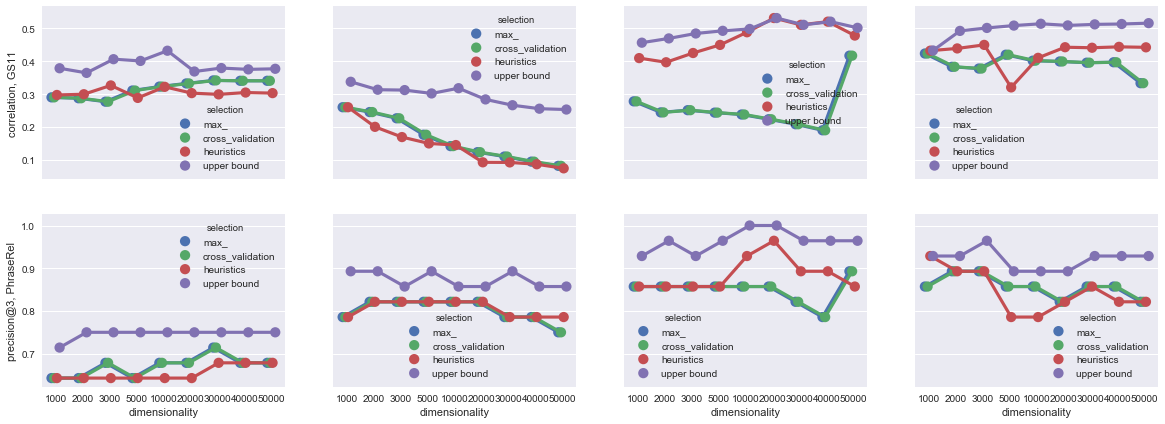

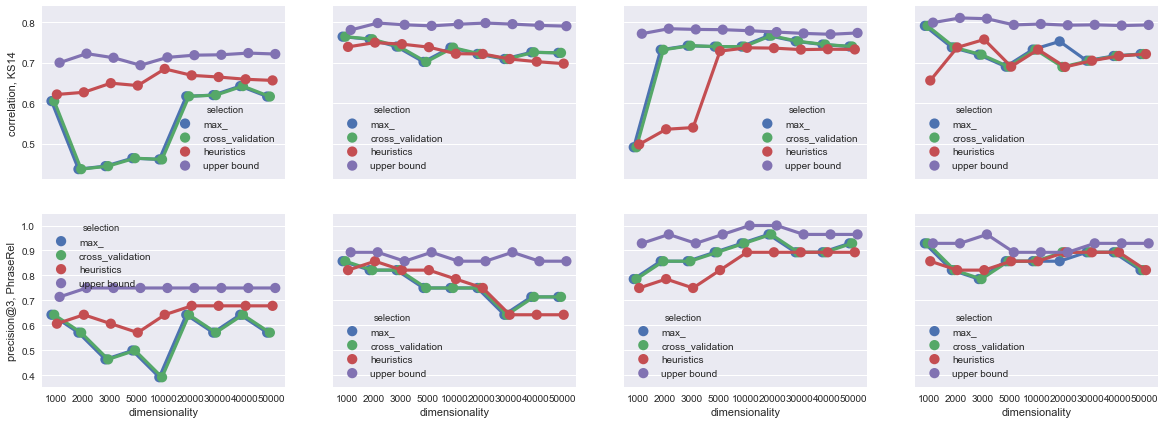

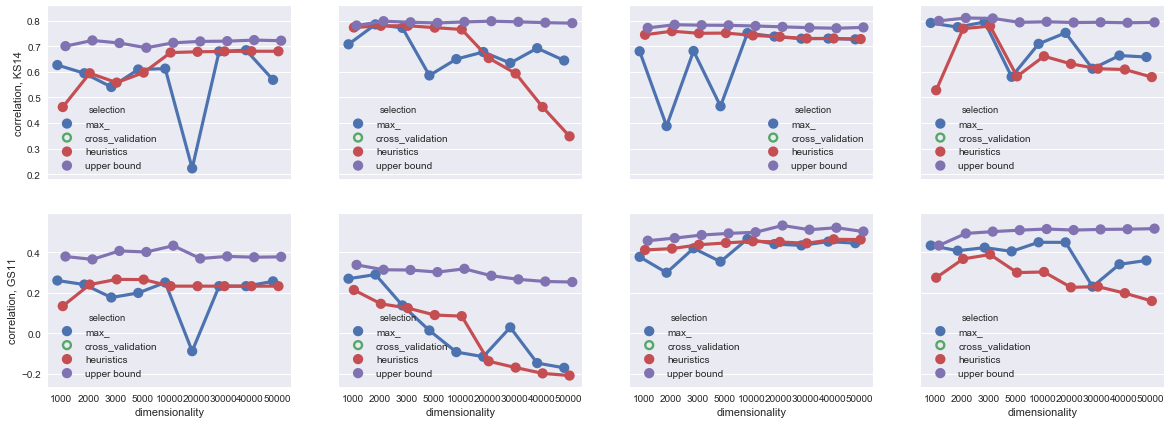

In [172]:
for from_i, from_ in enumerate(
    (
        'KS14',
        'GS11',
        'PhraseRel',
    )
):

    f, axarr = plt.subplots(
        2, 4,
        sharex=True,
        sharey='row',
        figsize=(2 * 10, 2 * 3.5),
    )

    ylabels = {'KS14': 'correlation', 'GS11': 'correlation', 'PhraseRel': 'precision@3'}
    for to_i, to_ in enumerate(t for t in ('KS14', 'GS11', 'PhraseRel') if t != from_):
        for operator_i, operator in enumerate(('head', 'add', 'mult', 'kron')):

            t.plot_parameter_selection_comparison(
                (
                    dataset_mapping[from_] +
                    [dataset_mapping[to_][0].assign(selection='upper bound')]
                ),
                from_,
                to_,
                ax=axarr[to_i, operator_i],
                operator=operator,
                ylabel='{}, {}'.format(ylabels[to_], to_) if operator_i == 0 else '',
                xlabel='' if to_i == 0 else None,
            )
            
#         if operator_i == 0:
#             axarr[to_i, operator_i].set(ylabel=ylabels[to_i])
        
    f.savefig('figures/{from_}-transfer.pdf'.format(from_=from_))

# Compositional

In [173]:
results['max', 'compositional'] = (
    (
        (results['max', 'KS14'] / results['max', 'KS14'].max()) +
        (results['max', 'GS11'] / results['max', 'GS11'].max()) +
        (results['max', 'PhraseRel'] / results['max', 'PhraseRel'].max())
    ) / 3
)

In [174]:
max_selection_compositional = t.plot_selection(
    results[
        results['max', 'KS14'].notnull() &
        results['max', 'GS11'].notnull()
    ],
    dataset='compositional',
    selector_function=t.max_('KS14', 'GS11', 'PhraseRel'),
    plot=False,
)

In [175]:
pd.concat(
    [
        max_selection_compositional.loc[
            ['head']
        ],        
        max_selection_compositional.loc[
            ['add', 'mult']
        ],
        max_selection_compositional.loc[
            ['kron']
        ],        
    ]
).round({'KS14': 2, 'GS11': 2, 'PhraseRel': 2, 'compositional': 2}).reset_index(drop=True).to_latex(
    'figures/compositional-max-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'KS14',
        'GS11',
        'PhraseRel',
        'compositional',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [176]:
'{:.2f}'.format(
    t.anova(
        response='compositional',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.77'

In [177]:
feature_ablation_compositional = t.calculate_feature_ablation(
    responses=(
        'compositional',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_compositional.sort_values(('partial R2', 'compositional'), ascending=False, inplace=True)

feature_ablation_compositional.round(2)

partial R2
response       compositional
predictor                   
neg                     0.40
freq                    0.29
operator                0.21
cds                     0.15
similarity              0.08
discr                   0.06
dimensionality          0.05

In [178]:
(
    feature_ablation_compositional['partial R2']
    .reset_index()
    .round({'compositional': 2})
    .to_latex('figures/compositional-ablation.tex', index=False)
)

In [179]:
heuristics_selection_collection_compositional = {}

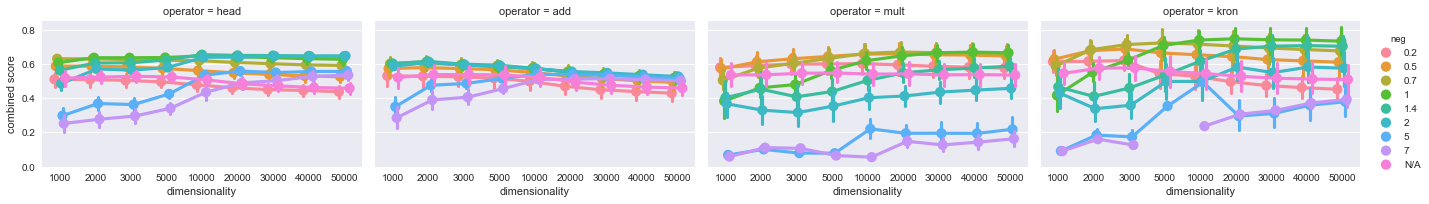

In [180]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_compositional.index[0], 'compositional', ylabels=['combined score'])

In [181]:
assert feature_ablation_compositional.index[0] == 'neg'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_compositional[0] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['neg'] == 1))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 1.4))) &

    (~((r['operator'] == 'add')) | ((r['neg'] == 1))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.5))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 0.7))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.7))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 1))) &

    True
]

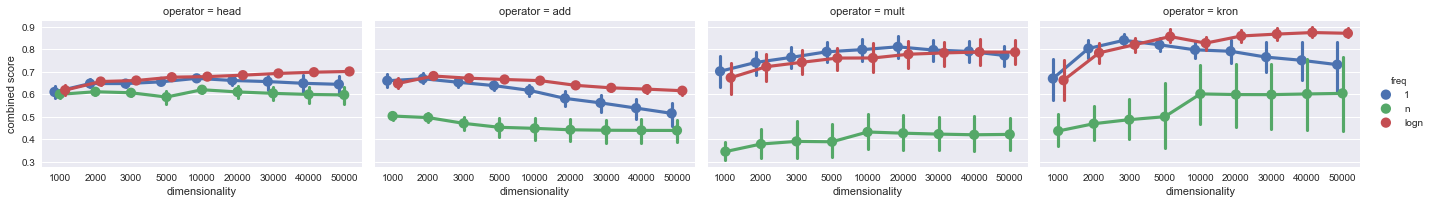

In [182]:
t.plot_interaction(heuristics_selection_collection_compositional[0], feature_ablation_compositional.index[1], 'compositional', ylabels=['combined score'])

In [183]:
assert feature_ablation_compositional.index[1] == 'freq'

r = heuristics_selection_collection_compositional[0]

heuristics_selection_collection_compositional[1] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['freq'] == 'logn'))) &
    (~((r['operator'] == 'add')) | ((r['freq'] == 'logn'))) &
    (~((r['operator'] == 'mult')) | ((r['freq'] == '1'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['freq'] == 'logn'))) &

    True
]

In [184]:
assert feature_ablation_compositional.index[2] == 'operator'

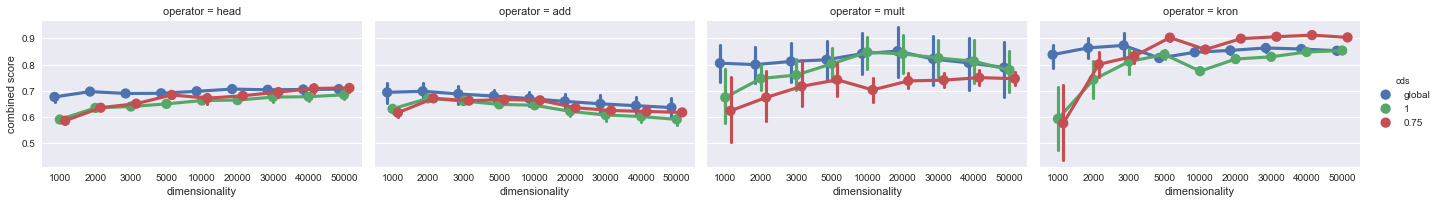

In [185]:
t.plot_interaction(heuristics_selection_collection_compositional[1], feature_ablation_compositional.index[3], 'compositional', ylabels=['combined score'])

In [186]:
assert feature_ablation_compositional.index[3] == 'cds'

r = heuristics_selection_collection_compositional[1]

heuristics_selection_collection_compositional[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'add')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['cds'] == 'global'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['cds'] == '0.75'))) &

    True
]

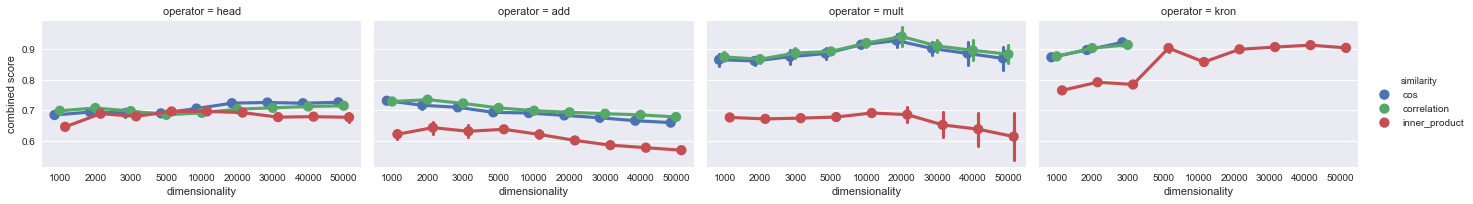

In [187]:
t.plot_interaction(heuristics_selection_collection_compositional[2], feature_ablation_compositional.index[4], 'compositional', ylabels=['combined score'])

In [188]:
assert feature_ablation_compositional.index[4] == 'similarity'

r = heuristics_selection_collection_compositional[2]

heuristics_selection_collection_compositional[3] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'cos'))) &

    (~((r['operator'] == 'add')) | ((r['similarity'] == 'correlation'))) &
    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'correlation'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'inner_product'))) &

    True
]

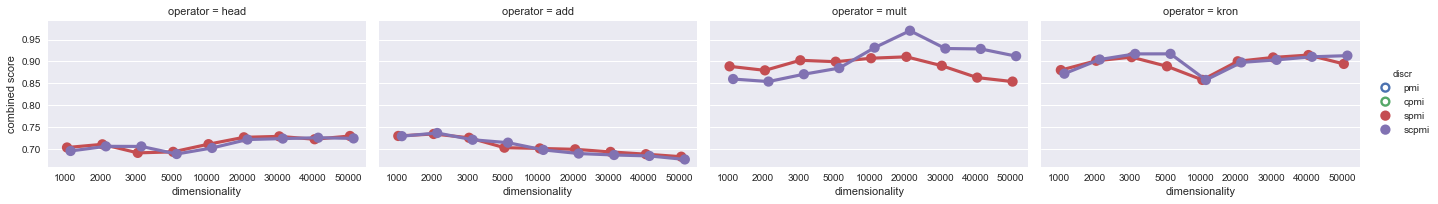

In [189]:
t.plot_interaction(heuristics_selection_collection_compositional[3], feature_ablation_compositional.index[5], 'compositional', ylabels=['combined score'])

In [190]:
assert feature_ablation_compositional.index[5] == 'discr'

r = heuristics_selection_collection_compositional[3]

heuristics_selection_collection_compositional[4] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['discr'] == 'spmi'))) &
    (~((r['operator'] == 'add')) | ((r['discr'] == 'spmi'))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['discr'] == 'spmi'))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['discr'] == 'scpmi'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 10000))) | ((r['discr'] == 'scpmi'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 10000))) | ((r['discr'] == 'spmi'))) &

    True
]

In [191]:
assert feature_ablation_compositional.index[6] == 'dimensionality'

In [192]:
assert len(feature_ablation_compositional) == 7

In [193]:
heuristics_selection_compositional = heuristics_selection_collection_compositional[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_compositional['selection'] = 'heuristics'
heuristics_selection_compositional.sort_index(inplace=True)

In [194]:
dataset_mapping['compositional'] = (
    max_selection_compositional,
    heuristics_selection_compositional,
)

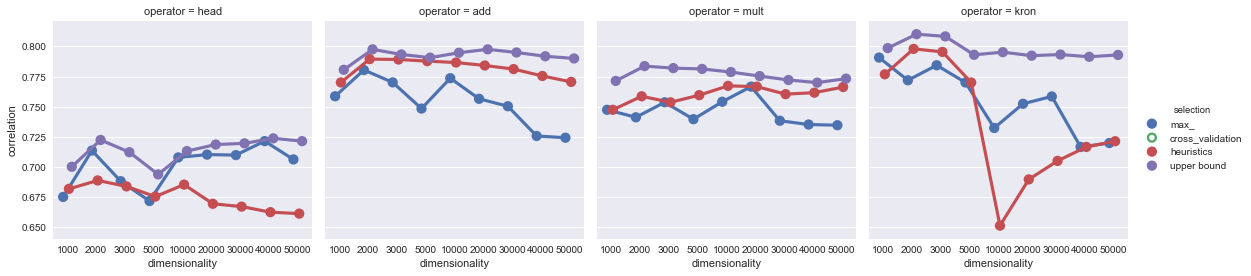

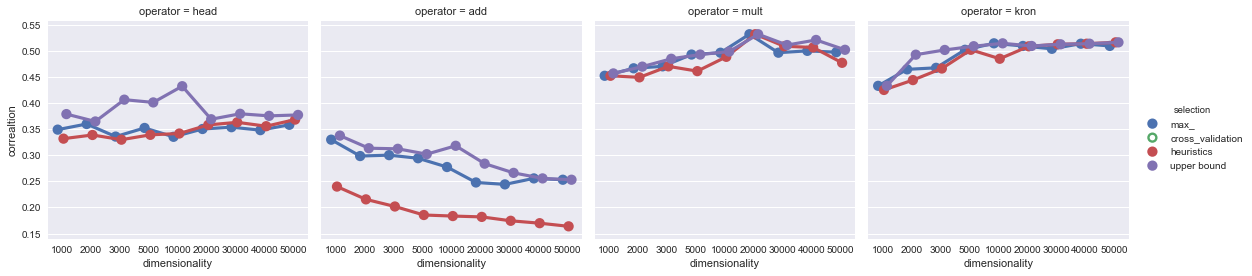

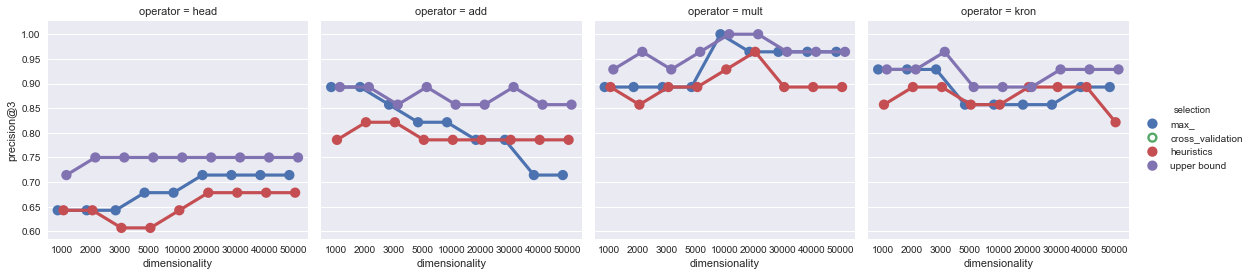

In [195]:
t.plot_parameter_selection_comparison(
    [
        max_selection_compositional,
        heuristics_selection_compositional,
        
        max_selection_ks14.assign(selection='upper bound')
    ],
    'KS14',
    'KS14',
    col='operator',
    ylabel='correlation',

).fig.savefig('figures/compositional-results-ks14.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_compositional,
        heuristics_selection_compositional,
        
        max_selection_gs11.assign(selection='upper bound'),
        max_selection_lexical.assign(selection='upper bound1', operator='add')
    ],
    'GS11',
    'GS11',
    col='operator',
    ylabel='correaltion',

).fig.savefig('figures/compositional-results-gs11.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_compositional,
        heuristics_selection_compositional,
        
        max_selection_phraserel.assign(selection='upper bound')
    ],
    'PhraseRel',
    'PhraseRel',
    col='operator',
    ylabel='precision@3',

).fig.savefig('figures/compositional-results-phraserel.pdf')

In [196]:
pd.concat(
    [
        heuristics_selection_compositional.loc[
            ['head', '']
        ],        
        heuristics_selection_compositional.loc[
            ['add', 'mult']
        ],
        heuristics_selection_compositional.loc[
            ['kron', '']
        ],        
    ]
).round({'KS14': 2, 'GS11': 2, 'PhraseRel': 2, 'compositional': 2}).reset_index(drop=True).to_latex(
    'figures/compositional-heuristics-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'KS14',
        'GS11',
        'PhraseRel',
        'compositional',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [197]:
for to_i, to_ in enumerate(('KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        print(
            '{from_} -> {to_}, {method}: {:.2f}'.format(
                t.average_error(
                    dataset_mapping[to_][0].loc[['head', 'add', 'mult', 'kron']],
                    dataset_mapping['compositional'][method_i].loc[['head', 'add', 'mult', 'kron']],
                    to_,
                ),
                from_='compositional',
                to_=to_,
                method=method,
            )
        )

compositional -> KS14, max: 0.04
compositional -> KS14, heuristics: 0.04
compositional -> GS11, max: 0.04
compositional -> GS11, heuristics: 0.13
compositional -> PhraseRel, max: 0.06
compositional -> PhraseRel, heuristics: 0.08


In [198]:
for to_i, to_ in enumerate(('KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        for operator in 'head', 'add', 'mult', 'kron':
            print(
                '{from_} -> {to_}, {method}, {operator}: {:.2f}'.format(
                    t.average_error(
                        dataset_mapping[to_][0].loc[operator],
                        dataset_mapping['compositional'][method_i].loc[operator],
                        to_,
                    ),
                    from_='compositional',
                    to_=to_,
                    method=method,
                    operator=operator,
                )
            )

compositional -> KS14, max, head: 0.02
compositional -> KS14, max, add: 0.05
compositional -> KS14, max, mult: 0.04
compositional -> KS14, max, kron: 0.05
compositional -> KS14, heuristics, head: 0.05
compositional -> KS14, heuristics, add: 0.01
compositional -> KS14, heuristics, mult: 0.02
compositional -> KS14, heuristics, kron: 0.08
compositional -> GS11, max, head: 0.10
compositional -> GS11, max, add: 0.05
compositional -> GS11, max, mult: 0.01
compositional -> GS11, max, kron: 0.02
compositional -> GS11, heuristics, head: 0.10
compositional -> GS11, heuristics, add: 0.35
compositional -> GS11, heuristics, mult: 0.03
compositional -> GS11, heuristics, kron: 0.03
compositional -> PhraseRel, max, head: 0.09
compositional -> PhraseRel, max, add: 0.07
compositional -> PhraseRel, max, mult: 0.03
compositional -> PhraseRel, max, kron: 0.04
compositional -> PhraseRel, heuristics, head: 0.13
compositional -> PhraseRel, heuristics, add: 0.09
compositional -> PhraseRel, heuristics, mult: 0.

# Uniersal

In [199]:
_results = results.unstack('operator')

for operator in (
    'add',
    'mult',
    'kron',
    'relational',
    'copy-object',
    'copy-subject',
    'frobenius-add',
    'frobenius-mult',
    'frobenius-outer',
):
    _results['max', 'SimLex999', operator] = _results['max', 'SimLex999', 'head']

    _results['max', 'men', operator] = _results['max', 'men', 'head']

_results = _results.stack('operator')
_results = _results.swaplevel('operator', 0).sort_index()

In [200]:
_results['max', 'universal'] = (
    _results['max', 'SimLex999'] / results['max', 'SimLex999'].max() / 4 +
    _results['max', 'men'] / results['max', 'men'].max() / 4 +

    _results['max', 'KS14'] / results['max', 'KS14'].max() / 6 +
    _results['max', 'GS11'] / results['max', 'GS11'].max() / 6 +
    _results['max', 'PhraseRel'] / results['max', 'PhraseRel'].max() / 6
)

In [201]:
max_selection_universal = t.plot_selection(
    _results.loc[['add', 'head', 'mult', 'kron']],
    dataset='universal',
    selector_function=t.max_('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel'),
    plot=False,
)

In [202]:
pd.concat(
    [
            max_selection_universal.loc[
                ['head', '']
            ],        
            max_selection_universal.loc[
                ['add', 'mult']
            ],
            max_selection_universal.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 2, 'men': 2,
        'KS14': 2, 'GS11': 2, 'PhraseRel': 2,
        'universal': 2,
    }
).reset_index(drop=True).to_latex(
    'figures/universal-max_-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'SimLex999',
        'men',
        'KS14',
        'GS11',
        'PhraseRel',
        'universal',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [203]:
'{:.2f}'.format(
    t.anova(
        response='universal',
        predictors=compositional_parameters,
        data=_results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.83'

In [204]:
feature_ablation_universal = t.calculate_feature_ablation(
    responses=(
        'universal',
    ),
    predictors=compositional_parameters,
    data=_results.loc[['add', 'head', 'mult', 'kron']],
)

feature_ablation_universal.sort_values(('partial R2', 'universal'), ascending=False, inplace=True)

feature_ablation_universal.round(2)

partial R2
response        universal
predictor                
freq                 0.32
neg                  0.29
similarity           0.22
cds                  0.10
discr                0.09
dimensionality       0.07
operator             0.05

In [205]:
(
    feature_ablation_universal['partial R2']
    .reset_index()
    .round({'universal': 2})
    .to_latex('figures/universal-ablation.tex', index=False)
)

In [206]:
heuristics_selection_collection_universal = {}

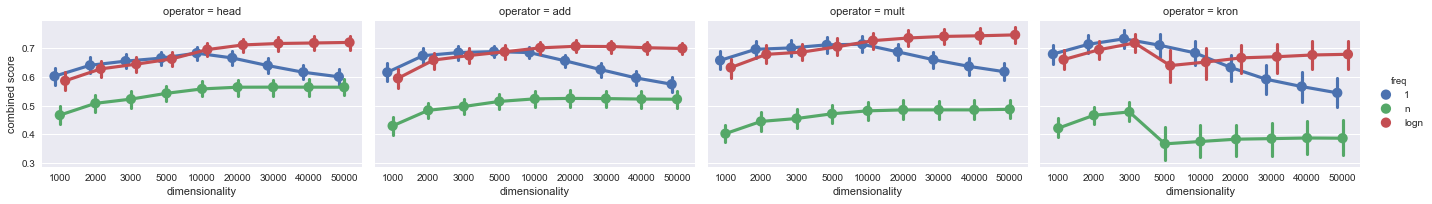

In [207]:
t.plot_interaction(_results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_universal.index[0], 'universal' , ylabels=['combined score'])

In [208]:
assert feature_ablation_universal.index[0] == 'freq'

r = _results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_universal[0] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'add') & (r['dimensionality'] < 10000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'add') & (r['dimensionality'] >= 10000))) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 20000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 20000))) | ((r['freq'] == 'logn'))) &

    True
]

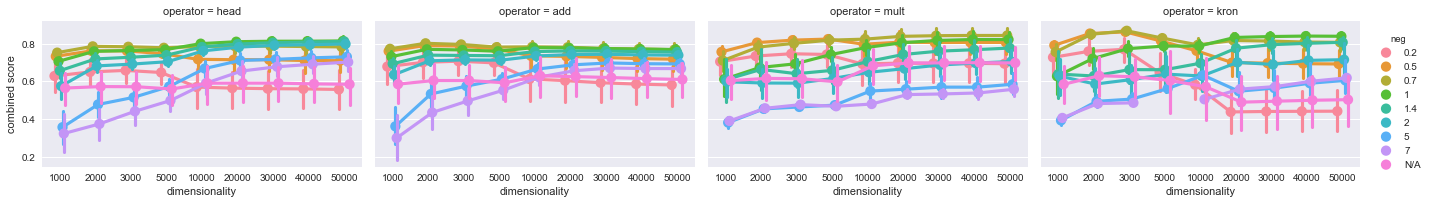

In [209]:
t.plot_interaction(heuristics_selection_collection_universal[0], feature_ablation_universal.index[1], 'universal', ylabels=['combined score'])

In [210]:
assert feature_ablation_universal.index[1] == 'neg'

r = heuristics_selection_collection_universal[0]

heuristics_selection_collection_universal[1] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.7))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 1))) &

    (~(((r['operator'] == 'add'))) | ((r['neg'] == 0.7))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.5))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 0.7))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 20000))) | ((r['neg'] == 0.7))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 20000))) | ((r['neg'] == 1))) &

    True
]

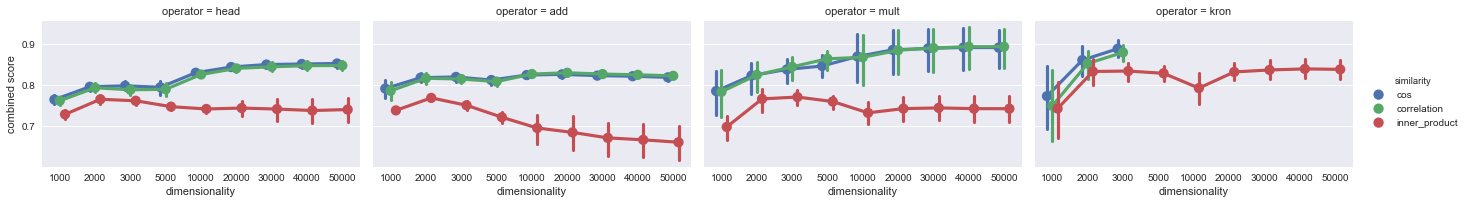

In [211]:
t.plot_interaction(heuristics_selection_collection_universal[1], feature_ablation_universal.index[2], 'universal', ylabels=['combined score'])

In [212]:
assert feature_ablation_universal.index[2] == 'similarity'

r = heuristics_selection_collection_universal[1]

heuristics_selection_collection_universal[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'add')) | ((r['similarity'] == 'correlation'))) &
    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'correlation'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'cos'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'inner_product'))) &

    True
]

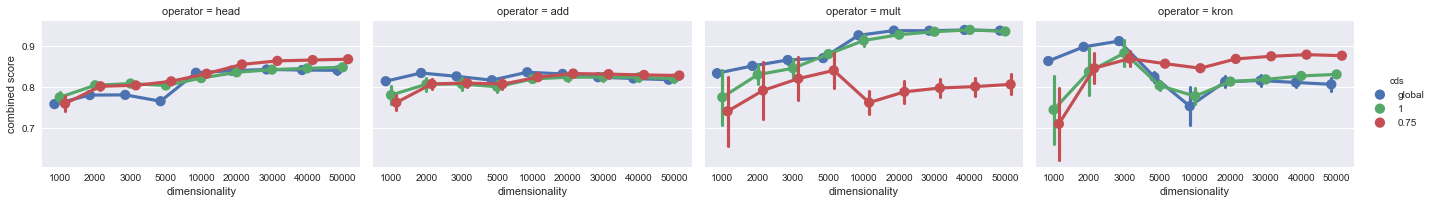

In [213]:
t.plot_interaction(heuristics_selection_collection_universal[2], feature_ablation_universal.index[3], 'universal', ylabels=['combined score'])

In [214]:
assert feature_ablation_universal.index[3] == 'cds'

r = heuristics_selection_collection_universal[2]

heuristics_selection_collection_universal[3] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['cds'] == '0.75'))) &

    (~(((r['operator'] == 'add') & (r['dimensionality'] < 20000))) | ((r['cds'] == 'global'))) &
    (~(((r['operator'] == 'add') & (r['dimensionality'] >= 20000))) | ((r['cds'] == '0.75'))) &
    
    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['cds'] == 'global'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['cds'] == '0.75'))) &

    True
]

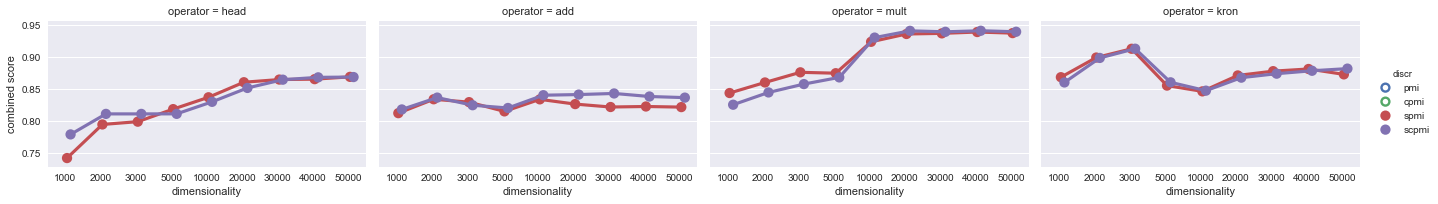

In [215]:
t.plot_interaction(heuristics_selection_collection_universal[3], feature_ablation_universal.index[4], 'universal', ylabels=['combined score'])

In [216]:
assert feature_ablation_universal.index[4] == 'discr'

r = heuristics_selection_collection_universal[3]

heuristics_selection_collection_universal[4] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'scpmi'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'spmi'))) &

    (~((r['operator'] == 'add')) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 10000)) | ((r['discr'] == 'spmi'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 10000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'kron')) | ((r['discr'] == 'spmi'))) &

    True
]

In [217]:
assert feature_ablation_universal.index[5] == 'dimensionality'

In [218]:
assert feature_ablation_universal.index[6] == 'operator'

In [219]:
assert len(feature_ablation_universal) == 7

In [220]:
heuristics_selection_universal = heuristics_selection_collection_universal[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_universal['selection'] = 'heuristics'
heuristics_selection_universal.sort_index(inplace=True)

In [221]:
pd.concat(
    [
            heuristics_selection_universal.loc[
                ['head', '']
            ],        
            heuristics_selection_universal.loc[
                ['add', 'mult']
            ],
            heuristics_selection_universal.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 2, 'men': 2,
        'KS14': 2, 'GS11': 2, 'PhraseRel': 2,
        'universal': 2,
    }
).reset_index(drop=True).to_latex(
    'figures/universal-heuristics-selection.tex',
    columns=[
        'operator',
        'dimensionality',
        'SimLex999',
        'men',
        'KS14',
        'GS11',
        'PhraseRel',
        'universal',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
    index=False,
)

In [222]:
_lexical_selections = pd.concat(
    [
        pd.concat(
            [
                _results.loc[operator].loc[max_selection_lexical.set_index([n for n in _results.index.names if n != 'operator']).index]
                ['max'].assign(operator=operator).reset_index().set_index(['operator', 'dimensionality'], drop=False)
                for operator in ('head', 'add', 'mult', 'kron')
            ]
        ).assign(selection='lexical, max_'),

        pd.concat(
            [
                _results.loc[operator].loc[heuristics_selection_lexical.set_index([n for n in _results.index.names if n != 'operator']).index]
                ['max'].assign(operator=operator).reset_index().set_index(['operator', 'dimensionality'], drop=False)
                for operator in ('head', 'add', 'mult', 'kron')
            ]
        ).assign(selection='lexical, heuristics'),

    ]
)

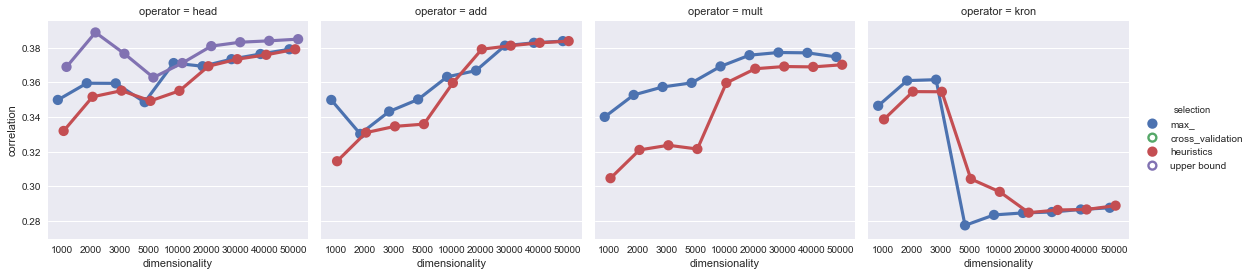

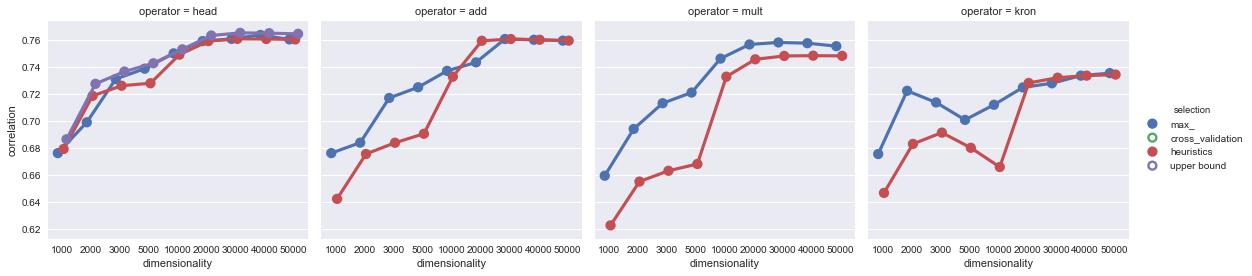

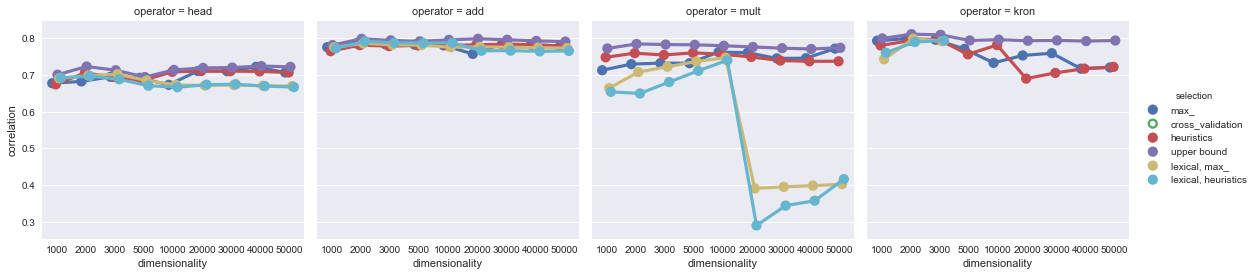

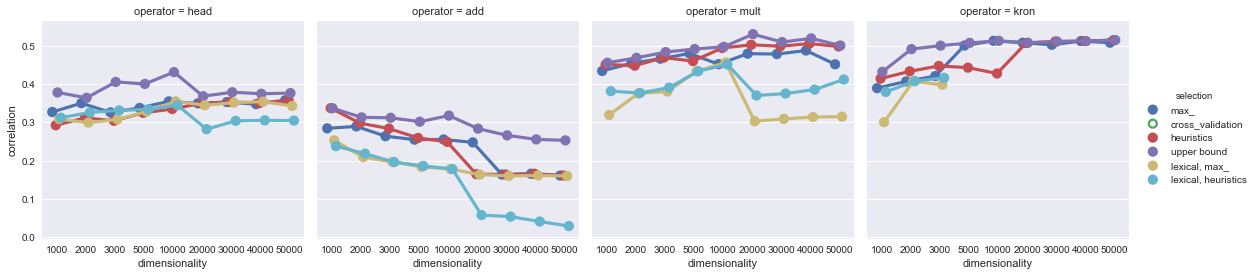

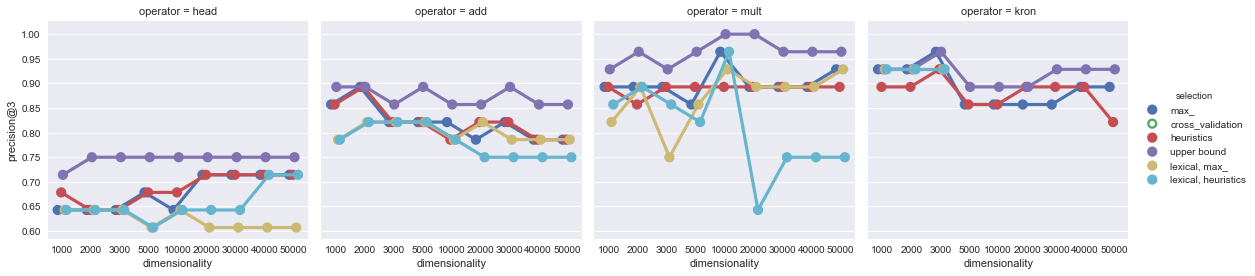

In [223]:
t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,

        max_selection_simlex.assign(selection='upper bound'),
    ],
    'SimLex999',
    'SimLex999',
    col='operator',
    ylabel='correlation',

).fig.savefig('figures/universal-results-simlex999.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_men.assign(selection='upper bound'),
],
    'men',
    'men',
    col='operator',
    ylabel='correlation',

).fig.savefig('figures/universal-results-men.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_ks14.assign(selection='upper bound'),
        
        _lexical_selections,
    ],
    'KS14',
    'KS14',
    col='operator',
    extra_hue=('lexical, max_', 'lexical, heuristics'),
    ylabel='correlation',
).fig.savefig('figures/universal-results-ks14.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_gs11.assign(selection='upper bound'),

        _lexical_selections,
    ],
    'GS11',
    'GS11',
    col='operator',
    extra_hue=('lexical, max_', 'lexical, heuristics'),
    ylabel='correlation',
).fig.savefig('figures/universal-results-gs11.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_phraserel.assign(selection='upper bound'),

        _lexical_selections,
    ],
    'PhraseRel',
    'PhraseRel',
    col='operator',
    extra_hue=('lexical, max_', 'lexical, heuristics'),
    ylabel='precision@3',
).fig.savefig('figures/universal-results-PhraseRel.pdf')

In [224]:
dataset_mapping['universal'] = max_selection_universal, heuristics_selection_universal

In [225]:
dataset_mapping['men'] = max_selection_men, heuristics_selection_men
dataset_mapping['SimLex999'] = max_selection_simlex, heuristics_selection_simlex

In [226]:
for to_i, to_ in enumerate(('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        print(
            '{from_} -> {to_}, {method}: {:.2f}'.format(
                t.average_error(
                    dataset_mapping[to_][0].loc[['head', 'add', 'mult', 'kron']],
                    dataset_mapping['universal'][method_i].loc[['head', 'add', 'mult', 'kron']],
                    to_,
                ),
                from_='universal',
                to_=to_,
                method=method,
            )
        )

universal -> SimLex999, max: 0.03
universal -> SimLex999, heuristics: 0.05
universal -> men, max: 0.01
universal -> men, heuristics: 0.01
universal -> KS14, max: 0.03
universal -> KS14, heuristics: 0.03
universal -> GS11, max: 0.11
universal -> GS11, heuristics: 0.11
universal -> PhraseRel, max: 0.06
universal -> PhraseRel, heuristics: 0.07


In [227]:
for to_i, to_ in enumerate(('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        for operator in 'head', 'add', 'mult', 'kron':
            operator_from = operator
            if to_ in ('SimLex999', 'men'):
                operator_from = 'head'

            print(
                '{from_} -> {to_}, {method}, {operator}: {:.2f}'.format(
                    t.average_error(
                        dataset_mapping[to_][0].loc[operator_from],
                        dataset_mapping['universal'][method_i].loc[operator],
                        to_,
                    ),
                    from_='universal',
                    to_=to_,
                    method=method,
                    operator=operator,
                )
            )

universal -> SimLex999, max, head: 0.03
universal -> SimLex999, max, add: 0.04
universal -> SimLex999, max, mult: 0.03
universal -> SimLex999, max, kron: 0.18
universal -> SimLex999, heuristics, head: 0.05
universal -> SimLex999, heuristics, add: 0.06
universal -> SimLex999, heuristics, mult: 0.09
universal -> SimLex999, heuristics, kron: 0.18
universal -> men, max, head: 0.01
universal -> men, max, add: 0.02
universal -> men, max, mult: 0.02
universal -> men, max, kron: 0.04
universal -> men, heuristics, head: 0.01
universal -> men, heuristics, add: 0.04
universal -> men, heuristics, mult: 0.06
universal -> men, heuristics, kron: 0.06
universal -> KS14, max, head: 0.03
universal -> KS14, max, add: 0.02
universal -> KS14, max, mult: 0.04
universal -> KS14, max, kron: 0.05
universal -> KS14, heuristics, head: 0.02
universal -> KS14, heuristics, add: 0.02
universal -> KS14, heuristics, mult: 0.04
universal -> KS14, heuristics, kron: 0.06
universal -> GS11, max, head: 0.10
universal -> GS

## One for all space

In [228]:
_ = _results.loc[['head', 'add', 'mult', 'kron']].unstack('operator')['max'][['SimLex999', 'men', 'GS11', 'KS14', 'PhraseRel']]

_single_score = pd.DataFrame(
    {
        'single': (
            _['SimLex999', 'head'] / _['SimLex999', 'head'].max()  / 4 +
            _['men', 'head'] / _['men', 'head'].max() / 4 +

            _['GS11', 'add'] / _['GS11', 'add'].max() / 12 +
            _['GS11', 'mult'] / _['GS11', 'mult'].max() / 12 +
#             _['GS11', 'kron'] / _['GS11', 'kron'].max() / 18 +

            _['KS14', 'add'] / _['KS14', 'add'].max() / 12 +
            _['KS14', 'mult'] / _['KS14', 'mult'].max() / 12 +
#             _['KS14', 'kron'] / _['KS14', 'kron'].max() / 18 +

            _['PhraseRel', 'add'] / _['PhraseRel', 'add'].max() / 12 +
            _['PhraseRel', 'mult'] / _['PhraseRel', 'mult'].max() / 12 +
#             _['PhraseRel', 'kron'] / _['PhraseRel', 'kron'].max() / 18 +
            0
        ),
    }
)

_results['max', 'single'] = pd.concat(
    [
        _single_score.assign(operator='head'),
        _single_score.assign(operator='add'),
        _single_score.assign(operator='mult'),
        _single_score.assign(operator='kron'),
    ]
).reset_index().set_index(_results.index.names)['single']


In [229]:
max_selection_single = t.plot_selection(
    _results.loc[['add', 'head', 'mult', 'kron']],
    dataset='single',
    selector_function=t.max_('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel', 'universal'),
    plot=False,
)

In [230]:
_ = pd.concat(
    [
            max_selection_single.loc[
                ['head', '']
            ],        
            max_selection_single.loc[
                ['add', 'mult']
            ],
            max_selection_single.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 2, 'men': 2,
        'KS14': 2, 'GS11': 2, 'PhraseRel': 2,
        'universal': 2,
    }
)

_ = _.set_index(compositional_parameters + ['reduction', 'base', 'context_type', 'corpus'])
_ = _.unstack('operator').swaplevel(0, 1, axis='columns')[
    [
        ('head', 'SimLex999'),
        ('head', 'men'),
        #('head', 'universal'),
        #('head', 'single'),

        #('head', 'KS14'),
        #('head', 'GS11'),
        #('head', 'PhraseRel'),

        ('add', 'KS14'),
        ('add', 'GS11'),
        ('add', 'PhraseRel'),
        #('add', 'universal'),

        ('mult', 'KS14'),
        ('mult', 'GS11'),
        ('mult', 'PhraseRel'),

        ('kron', 'KS14'),
        ('kron', 'GS11'),
        ('kron', 'PhraseRel'),
    ]
].reset_index(['reduction', 'base', 'context_type', 'corpus'], drop=True)

_.to_latex(
    'figures/single-max_-selection.tex',
)

_

operator                                              head         add        \
                                                 SimLex999   men  KS14  GS11   
dimensionality discr cds    freq neg similarity                                
1000           scpmi global 1    0.7 cos              0.33  0.65  0.74  0.32   
2000           scpmi global 1    0.7 cos              0.35  0.68  0.75  0.29   
3000           scpmi global 1    0.7 cos              0.35  0.69  0.76  0.29   
5000           cpmi  1      logn N/A correlation      0.35  0.73  0.78  0.25   
10000          scpmi global logn 0.7 correlation      0.36  0.73  0.78  0.25   
20000          cpmi  1      logn N/A correlation      0.37  0.75  0.78  0.24   
30000          scpmi 1      logn 0.7 correlation      0.37  0.76  0.78  0.17   
40000          scpmi 1      logn 0.7 correlation      0.37  0.76  0.78  0.17   
50000          scpmi global logn 0.7 correlation      0.37  0.75  0.76  0.20   

operator                                                    mult        \
                                                 PhraseRel  KS14  GS11   
dimensionality discr cds    freq neg similarity                          
1000           scpmi global 1    0.7 cos              0.86  0.73  0.44   
2000           scpmi global 1    0.7 cos              0.79  0.74  0.45   
3000           scpmi global 1    0.7 cos              0.82  0.74  0.48   
5000           cpmi  1      logn N/A correlation      0.82  0.75  0.43   
10000          scpmi global logn 0.7 correlation      0.79  0.76  0.50   
20000          cpmi  1      logn N/A correlation      0.71  0.74  0.44   
30000          scpmi 1      logn 0.7 correlation      0.79  0.75  0.48   
40000          scpmi 1      logn 0.7 correlation      0.79  0.75  0.49   
50000          scpmi global logn 0.7 correlation      0.71  0.74  0.50   

operator                                                    kron        \
                                                 PhraseRel  KS14  GS11   
dimensionality discr cds    freq neg similarity                          
1000           scpmi global 1    0.7 cos              0.89  0.76  0.43   
2000           scpmi global 1    0.7 cos              0.82  0.78  0.44   
3000           scpmi global 1    0.7 cos              0.86  0.78  0.47   
5000           cpmi  1      logn N/A correlation      0.89   NaN   NaN   
10000          scpmi global logn 0.7 correlation      0.89   NaN   NaN   
20000          cpmi  1      logn N/A correlation      1.00   NaN   NaN   
30000          scpmi 1      logn 0.7 correlation      0.89   NaN   NaN   
40000          scpmi 1      logn 0.7 correlation      0.89   NaN   NaN   
50000          scpmi global logn 0.7 correlation      0.89   NaN   NaN   

operator                                                    
                                                 PhraseRel  
dimensionality discr cds    freq neg similarity             
1000           scpmi global 1    0.7 cos              0.86  
2000           scpmi global 1    0.7 cos              0.89  
3000           scpmi global 1    0.7 cos              0.93  
5000           cpmi  1      logn N/A correlation       NaN  
10000          scpmi global logn 0.7 correlation       NaN  
20000          cpmi  1      logn N/A correlation       NaN  
30000          scpmi 1      logn 0.7 correlation       NaN  
40000          scpmi 1      logn 0.7 correlation       NaN  
50000          scpmi global logn 0.7 correlation       NaN

In [231]:
'{:.2f}'.format(
    t.anova(
        response='single',
        predictors=parameters,
        data=_results.loc[['add', 'head', 'mult']],
    ).rsquared_adj
)

'0.90'

In [232]:
feature_ablation_single = t.calculate_feature_ablation(
    responses=(
        'single',
    ),
    predictors=parameters,
    data=_results.loc[['head', 'add', 'mult']],
)

feature_ablation_single.sort_values(('partial R2', 'single'), ascending=False, inplace=True)

feature_ablation_single.round(2)

partial R2
response           single
predictor                
freq                 0.43
similarity           0.27
neg                  0.20
discr                0.09
cds                  0.09
dimensionality       0.03

In [233]:
(
    feature_ablation_single['partial R2']
    .reset_index()
    .round({'single': 2})
    .to_latex('figures/single-ablation.tex', index=False)
)

In [234]:
heuristics_selection_collection_single = {}

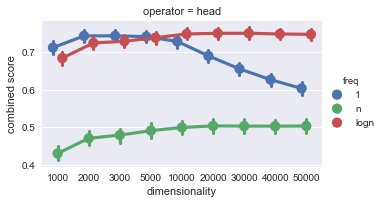

In [235]:
t.plot_interaction(_results.loc[['add', 'head', 'mult'], 'max'], feature_ablation_single.index[0], 'single', ylabels=['combined score'])

In [236]:
assert feature_ablation_single.index[0] == 'freq'

r = _results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_single[0] =  r.loc[
    (~(((r['dimensionality'] < 20000))) | ((r['freq'] == '1'))) &
    (~(((r['dimensionality'] >= 20000))) | ((r['freq'] == 'logn'))) &

    True
]

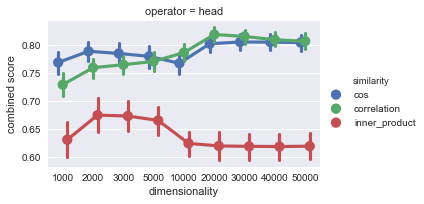

In [237]:
t.plot_interaction(heuristics_selection_collection_single[0], feature_ablation_single.index[1], 'single', ylabels=['combined score'])

In [238]:
assert feature_ablation_single.index[1] == 'similarity'

r = heuristics_selection_collection_single[0]

heuristics_selection_collection_single[1] =  r.loc[
    (~(((r['dimensionality'] < 20000))) | ((r['similarity'] == 'cos'))) &
    (~(((r['dimensionality'] >= 20000))) | ((r['similarity'] == 'correlation'))) &

    True
]

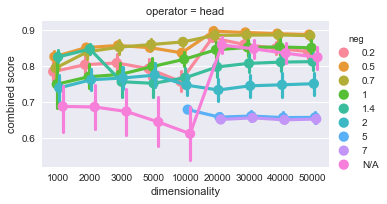

In [239]:
t.plot_interaction(heuristics_selection_collection_single[1], feature_ablation_single.index[2], 'single', ylabels=['combined score'])

In [240]:
assert feature_ablation_single.index[2] == 'neg'

r = heuristics_selection_collection_single[1]

heuristics_selection_collection_single[2] =  r.loc[
    (r['neg'] == 0.7)
]

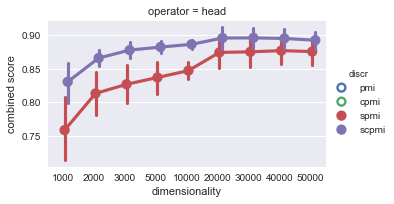

In [241]:
t.plot_interaction(heuristics_selection_collection_single[2], feature_ablation_single.index[3], 'single', ylabels=['combined score'])

In [242]:
assert feature_ablation_single.index[3] == 'discr'

r = heuristics_selection_collection_single[2]

heuristics_selection_collection_single[3] =  r.loc[
    (r['discr'] == 'scpmi')
]

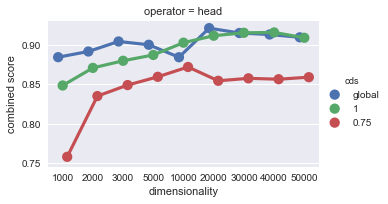

In [243]:
t.plot_interaction(heuristics_selection_collection_single[3], feature_ablation_single.index[4], 'single', ylabels=['combined score'])

In [244]:
assert feature_ablation_single.index[4] == 'cds'

r = heuristics_selection_collection_single[3]

heuristics_selection_collection_single[4] =  r.loc[
    (r['cds'] == 'global')
]

In [245]:
assert feature_ablation_single.index[5] == 'dimensionality'

In [246]:
assert len(feature_ablation_single.index) == 6

In [247]:
heuristics_selection_single = heuristics_selection_collection_single[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_single['selection'] = 'heuristics'
heuristics_selection_single.sort_index(inplace=True)

In [248]:
_ = pd.concat(
    [
            heuristics_selection_single.loc[
                ['head', '']
            ],        
            heuristics_selection_single.loc[
                ['add', 'mult']
            ],
            heuristics_selection_single.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 2, 'men': 2,
        'KS14': 2, 'GS11': 2, 'PhraseRel': 2,
        'universal': 2, 'single': 2,
    }
)

_ = _.set_index(compositional_parameters + ['reduction', 'base', 'context_type', 'corpus'])
_ = _.unstack('operator').swaplevel(0, 1, axis='columns')[
    [
        ('head', 'SimLex999'),
        ('head', 'men'),
        #('head', 'universal'),
        #('head', 'single'),

        #('head', 'KS14'),
        #('head', 'GS11'),
        #('head', 'PhraseRel'),

        ('add', 'KS14'),
        ('add', 'GS11'),
        ('add', 'PhraseRel'),
        #('add', 'universal'),

        ('mult', 'KS14'),
        ('mult', 'GS11'),
        ('mult', 'PhraseRel'),

        ('kron', 'KS14'),
        ('kron', 'GS11'),
        ('kron', 'PhraseRel'),
    ]
].reset_index(['reduction', 'base', 'context_type', 'corpus'], drop=True)

_.to_latex(
    'figures/single-heuristics-selection.tex',
)

_

operator                                              head         add        \
                                                 SimLex999   men  KS14  GS11   
dimensionality discr cds    freq neg similarity                                
1000           scpmi global 1    0.7 cos              0.33  0.65  0.74  0.32   
2000           scpmi global 1    0.7 cos              0.35  0.68  0.75  0.29   
3000           scpmi global 1    0.7 cos              0.35  0.69  0.76  0.29   
5000           scpmi global 1    0.7 cos              0.34  0.70  0.75  0.27   
10000          scpmi global 1    0.7 cos              0.33  0.70  0.74  0.24   
20000          scpmi global logn 0.7 correlation      0.37  0.75  0.77  0.23   
30000          scpmi global logn 0.7 correlation      0.37  0.75  0.77  0.22   
40000          scpmi global logn 0.7 correlation      0.37  0.75  0.77  0.21   
50000          scpmi global logn 0.7 correlation      0.37  0.75  0.76  0.20   

operator                                                    mult        \
                                                 PhraseRel  KS14  GS11   
dimensionality discr cds    freq neg similarity                          
1000           scpmi global 1    0.7 cos              0.86  0.73  0.44   
2000           scpmi global 1    0.7 cos              0.79  0.74  0.45   
3000           scpmi global 1    0.7 cos              0.82  0.74  0.48   
5000           scpmi global 1    0.7 cos              0.82  0.74  0.49   
10000          scpmi global 1    0.7 cos              0.75  0.75  0.49   
20000          scpmi global logn 0.7 correlation      0.75  0.75  0.50   
30000          scpmi global logn 0.7 correlation      0.71  0.74  0.50   
40000          scpmi global logn 0.7 correlation      0.71  0.74  0.51   
50000          scpmi global logn 0.7 correlation      0.71  0.74  0.50   

operator                                                    kron        \
                                                 PhraseRel  KS14  GS11   
dimensionality discr cds    freq neg similarity                          
1000           scpmi global 1    0.7 cos              0.89  0.76  0.43   
2000           scpmi global 1    0.7 cos              0.82  0.78  0.44   
3000           scpmi global 1    0.7 cos              0.86  0.78  0.47   
5000           scpmi global 1    0.7 cos              0.89   NaN   NaN   
10000          scpmi global 1    0.7 cos              0.93   NaN   NaN   
20000          scpmi global logn 0.7 correlation      0.89   NaN   NaN   
30000          scpmi global logn 0.7 correlation      0.89   NaN   NaN   
40000          scpmi global logn 0.7 correlation      0.89   NaN   NaN   
50000          scpmi global logn 0.7 correlation      0.89   NaN   NaN   

operator                                                    
                                                 PhraseRel  
dimensionality discr cds    freq neg similarity             
1000           scpmi global 1    0.7 cos              0.86  
2000           scpmi global 1    0.7 cos              0.89  
3000           scpmi global 1    0.7 cos              0.93  
5000           scpmi global 1    0.7 cos               NaN  
10000          scpmi global 1    0.7 cos               NaN  
20000          scpmi global logn 0.7 correlation       NaN  
30000          scpmi global logn 0.7 correlation       NaN  
40000          scpmi global logn 0.7 correlation       NaN  
50000          scpmi global logn 0.7 correlation       NaN

# Frobenius operators

In [249]:
selection_to_test = pd.concat(
    [
        max_selection_universal[max_selection_universal['dimensionality'] < 5000][parameters].assign(
            selection='universal_max'
        ).set_index('selection', append=True).reorder_levels(['selection', 'operator', 'dimensionality']),

        heuristics_selection_universal.loc[['head', 'add', 'mult', 'kron']][
            heuristics_selection_universal.loc[['head', 'add', 'mult', 'kron']]['dimensionality'] < 5000
        ][parameters].assign(
            selection='universal_heuristics'
        ).set_index('selection', append=True).reorder_levels(['selection', 'operator', 'dimensionality']),

        max_selection_single[max_selection_single['dimensionality'] < 5000][parameters].assign(
            selection='single'
        ).set_index('selection', append=True, drop=False).loc[['head']].reorder_levels(['selection', 'operator', 'dimensionality']),

#         heuristics_selection_single.loc[['head']][
#             heuristics_selection_single.loc[['head']]['dimensionality'] < 5000
#         ][parameters].assign(
#             selection='single_heuristics'
#         ).set_index('selection', append=True).reorder_levels(['selection', 'operator', 'dimensionality']),
    ]
)

In [250]:
frobenius_results = selection_to_test.merge(
    _results.loc[
        [
            'relational',
            'copy-object',
            'copy-subject',
            'frobenius-add',
            'frobenius-mult',
            'frobenius-outer',
        ],
        'max',
    ]
    .reset_index('operator')
    .reset_index(['corpus', 'reduction', 'base', 'context_type'], drop=True)
    .reorder_levels(parameters),
    left_on=parameters,
    right_index=True,
    how='left',
).sortlevel()

In [251]:
frobenius_results['selection'] = frobenius_results.index.get_level_values('selection')
frobenius_results['selection_operator'] = frobenius_results.index.get_level_values('operator')

frobenius_results['selection_name'] = frobenius_results['selection'] + '_' + frobenius_results['selection_operator']

In [252]:
_ = frobenius_results[
    (frobenius_results['selection_operator'] != 'head') |
    (frobenius_results['selection'] == 'single')
].replace({'selection_operator': {'head': ''}}).drop(
    [
        'lexical', 'compositional', 'universal', 'single',
    ],
    axis='columns'
).reset_index(drop=True).set_index(
    ['selection', 'selection_operator', 'dimensionality', 'freq', 'discr', 'neg', 'cds', 'operator',]
).drop('similarity', axis='columns').sortlevel()

# _ = _[~_.index.duplicated()]

_ = _.unstack('operator')

_ = _[['KS14', 'GS11', 'PhraseRel']].round(2).fillna('')

_ = pd.concat(
    [
        _.loc['single', '', :],
        _.loc['universal_max', 'add', :],
        _.loc['universal_max', 'mult', :],
        _.loc['universal_max', 'kron', :],
        _.loc['universal_heuristics', 'add', :],
        _.loc['universal_heuristics', 'mult', :],
        _.loc['universal_heuristics', 'kron', :],
    ]
)

for dataset in 'KS14', 'GS11', 'PhraseRel':
    _[dataset].to_latex('figures/frobenius-{}-results.tex'.format(dataset), sparsify=False)


In [254]:
_ = frobenius_results.groupby(['operator']).max()[['KS14', 'GS11', 'PhraseRel']].round(2)
_ = pd.concat(
    [
        pd.concat(
            [
                max_selection_universal,
                heuristics_selection_universal,
                max_selection_single,
                heuristics_selection_single,
            ]
        ).groupby(level='operator').max().round(2),
        _
    ]
).fillna('')

_ = pd.concat(
    [
        _.loc[
            [
                'add', 'mult', 'kron',
                'relational', 'copy-object', 'copy-subject',
                'frobenius-add', 'frobenius-mult', 'frobenius-outer',
            ]
        ]
    ]
)[['KS14', 'GS11', 'PhraseRel']]

_.to_latex('figures/frobenius-results.tex')
_

KS14  GS11  PhraseRel
operator                              
add              0.79  0.34       0.89
mult             0.77  0.51       1.00
kron             0.80  0.52       0.96
relational       0.77  0.39       0.89
copy-object      0.63  0.28       0.82
copy-subject     0.74  0.40       0.82
frobenius-add    0.76  0.37       0.82
frobenius-mult   0.75  0.30       0.86
frobenius-outer  0.77  0.38       0.89

In [ ]:
pd.concat(
    [
        max_selection_universal,
        heuristics_selection_universal,
        max_selection_single,
        heuristics_selection_single,
    ]
).max()[['SimLex999', 'men']].round(3)

In [ ]:
import seaborn as sns

In [ ]:
(
    frobenius_results.groupby(['dimensionality', 'freq', 'discr', 'neg', 'cds', 'operator']).max()
    [['KS14', 'GS11', 'PhraseRel']]
    .unstack('operator').round(3)
)

In [ ]:
for dataset in 'KS14', 'GS11', 'PhraseRel':
    g = sns.factorplot(
        data=frobenius_results.replace(
            {
                'selection_name': {
                    'single_head': 'single',

                    'universal_max_add': 'Max add',
                    'universal_max_mult': 'Max mult',
                    'universal_max_kron': 'Max Kronecker',

                    'universal_heuristics_add': 'Heuristics add',
                    'universal_heuristics_mult': 'Heuristics mult',
                    'universal_heuristics_kron': 'Heuristics Kronecker',
                }
            }
        ),
        y=dataset,
        x='dimensionality',
        hue='selection_name',
        hue_order=[
            'single',
            'Max add', 'Max mult', 'Max Kronecker',
            'Heuristics add', 'Heuristics mult', 'Heuristics Kronecker',
        ],
        markers=['.', '+', '*', 'd', '+', '*', 'd'],
        col='operator',
        col_order=[
            'relational',
            'copy-object',
            'copy-subject',
            'frobenius-add',
            'frobenius-mult',
            'frobenius-outer',
        ],
        col_wrap=3,
        dodge=0.4,
#         kind='strip',
        linestyles='',
        palette=[
            sns.color_palette()[0],
            sns.color_palette()[1], sns.color_palette()[1], sns.color_palette()[1],
            sns.color_palette()[2], sns.color_palette()[2], sns.color_palette()[2],
        ]
    )
    
    g.fig.savefig('figures/frobenius-{}-plot.pdf'.format(dataset))

In [ ]:
dataset_mapping['single'] = max_selection_single, heuristics_selection_single

In [ ]:
for to_i, to_ in enumerate(('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        print(
            '{from_} -> {to_}, {method}: {:.3f}'.format(
                t.average_error(
                    dataset_mapping[to_][0].loc[['head', 'add', 'mult', 'kron']],
                    dataset_mapping['single'][method_i].loc[['head', 'add', 'mult', 'kron']],
                    to_,
                ),
                from_='single',
                to_=to_,
                method=method,
            )
        )

In [ ]:
for to_i, to_ in enumerate(('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        for operator in 'head', 'add', 'mult', 'kron':
            operator_from = operator
            if to_ in ('SimLex999', 'men'):
                operator_from = 'head'

            print(
                '{from_} -> {to_}, {method}, {operator}: {:.3f}'.format(
                    t.average_error(
                        dataset_mapping[to_][0].loc[operator_from],
                        dataset_mapping['single'][method_i].loc[operator],
                        to_,
                    ),
                    from_='single',
                    to_=to_,
                    method=method,
                    operator=operator,
                )
            )